In [1]:
%reload_ext autoreload
%autoreload 2
import slap2_py as spy
import wisco_slap as wis
import wisco_slap.defs as DEFS
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import h5py
import glob
import polars as pl
from pathlib import Path
import tifffile
import seaborn as sns
import electro_py as epy
import cv2

In [2]:
subject = 'avior'
exp = 'exp_2'
sb = 1
locs = ['loc_C']
loc = 'loc_C'
acq = 'acq_2'

In [3]:
esum_path = wis.util.info.sub_esum_path(subject, exp, loc, acq)

In [105]:
lsdf = wis.scope.io.load_lsdf(subject, exp, loc, acq, apply_ephys_offset=True)

In [126]:
t1 = 1910
t2 = t1 + 10

In [137]:
dd = lsdf.filter(pl.col('time').is_between(t1, t2)).filter(pl.col('dmd')==2).filter(pl.col('source')==0).filter(pl.col('channel')==2)['data'].to_numpy()

In [139]:
# check if there are any nan values in the array
np.isnan(dd).sum()

# set those nan values to zero
# dd may be a read-only array; create a writable copy with NaNs replaced
dd = np.nan_to_num(dd, copy=True, nan=0.0)

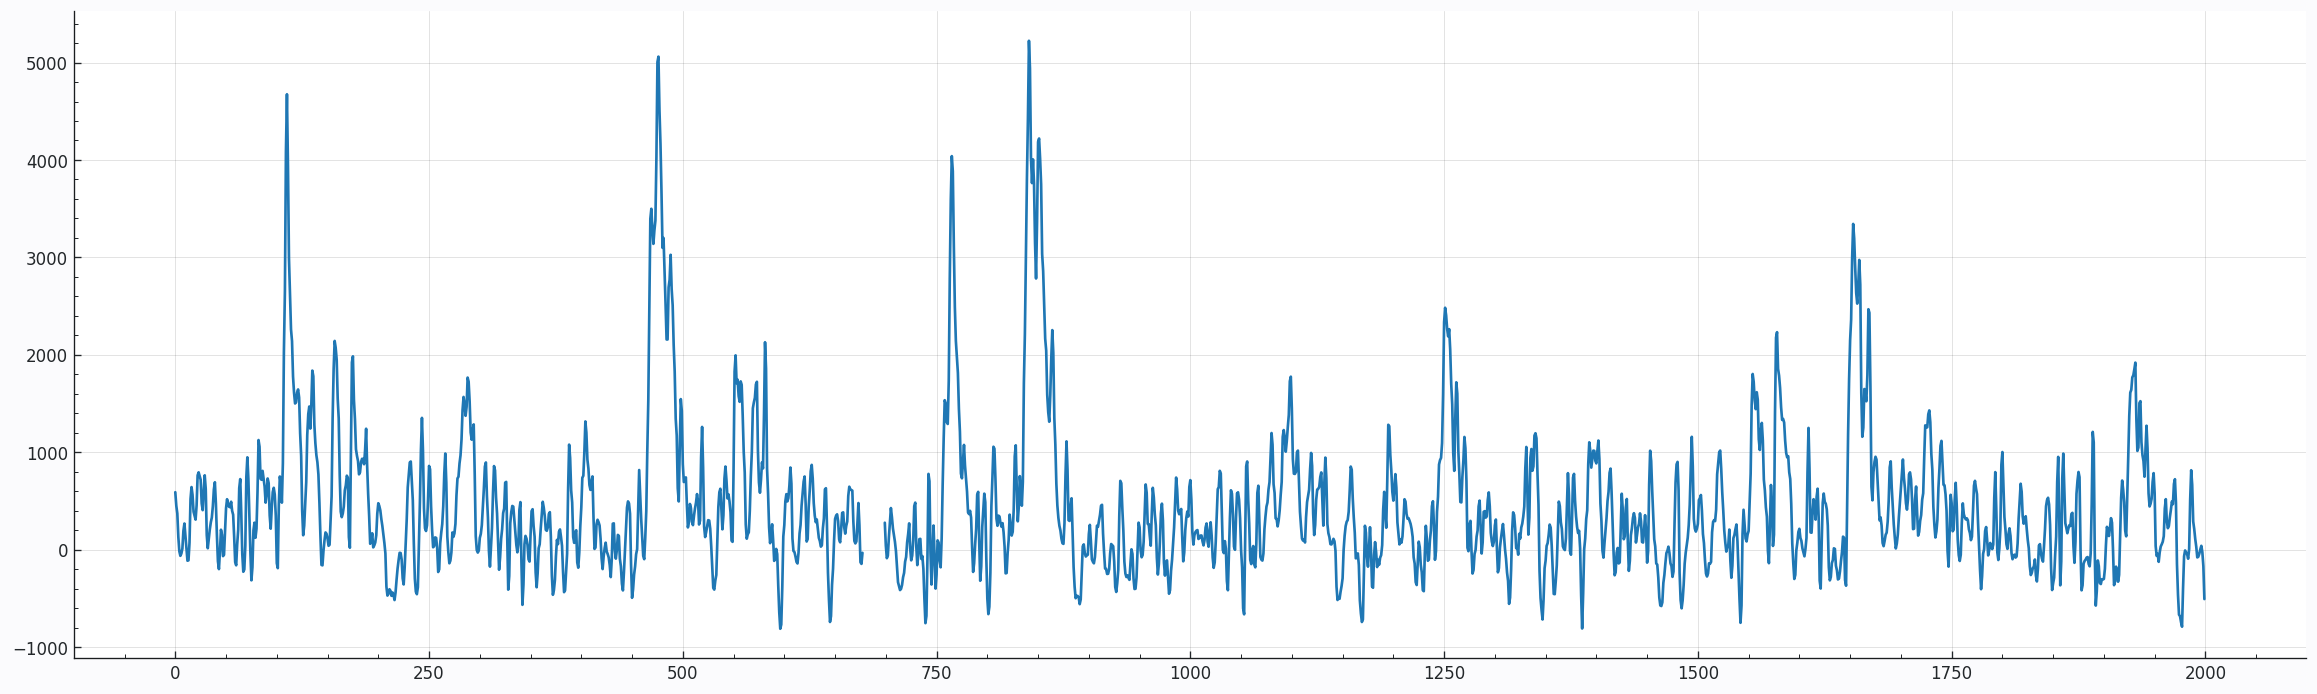

In [128]:
f, ax = plt.subplots(1, 1, figsize=(24, 7))
ax.plot(dd)

In [141]:
path = '/Users/driessen2@ad.wisc.edu/kdriessen/slap_wi_master/ophys-slap2-analysis/sample_data.npy'
np.save(path, dd)

In [4]:
tt = ['matchFilt', 'events']
soma_dfs = []
for loc in locs:
    soma_df = wis.scope.io.load_roidf(subject, exp, loc, acq, apply_ephys_offset=True)
    soma_dfs.append(soma_df)
sdf = pl.concat(soma_dfs)
syndfs = []
for loc in locs:
    syndf = wis.scope.io.load_syndf(subject, exp, loc, acq, trace_types=tt, apply_ephys_offset=True)
    syndfs.append(syndf)
syndf = pl.concat(syndfs)
sdf = sdf.sort('time', descending=False)
syndf = syndf.sort('time', descending=False)

In [5]:
mf = syndf.filter(pl.col('trace_type') == 'matchFilt')
ev = syndf.filter(pl.col('trace_type') == 'events')

In [66]:
f0 = spy.hf.hcore.load_f0_full_helper(esum_path)

In [ ]:
def detect_events(df):
    # Placeholder for event detection logic
    assert len(df['trace_type'].unique() == 1), "DataFrame must contain only one trace type"
    trace_type = df['trace_type'][0]
    if trace_type == 'matchFilt':
        _run_matchfilt_event_detection(df)
    elif trace_type == 'events':
        _run_events_event_detection(df)
    else:
        raise ValueError(f"Unknown trace type: {trace_type}")

In [6]:
noise_mf = spy.hf.hcore.load_noise_estimates(esum_path, group='dF', ttype='matchFilt')
noise_ev = spy.hf.hcore.load_noise_estimates(esum_path, group='dF', ttype='events')
ntrials = len(noise_mf[1])

In [7]:
trial_shape = spy.hf.hcore.get_trial_shape(esum_path, dmd=1, key='F0')
len_trial = trial_shape[1]

In [8]:
unique_times = mf.filter(pl.col('dmd')==1).filter(pl.col('source')==0)['time'].to_numpy()

In [10]:
ntrials

370

In [11]:
trial_labels = []
for ti in range(ntrials):
    labels_for_trial = np.ones(len_trial) * ti
    trial_labels.append(labels_for_trial)
trial_labels = np.concatenate(trial_labels)
trial_labels
trial_df = pl.DataFrame({'time': unique_times, 'trial': trial_labels})
mf = mf.join(trial_df, on='time')
ev = ev.join(trial_df, on='time')

In [12]:
noise_dfs = []
for dmd in [1, 2]:
    nest = noise_mf[dmd]
    for trial in range(ntrials):
        noise_vals = nest[trial].flatten()
        std = np.sqrt(noise_vals)
        std3 = 3 * std
        sources = np.arange(len(noise_vals))
        source = pl.Series('source', sources)
        tdf = pl.DataFrame({'source': source,
                            'trial': trial,
                            'noise_est': std,
                            'noise_est_3sd': std3,
                            'dmd': dmd})
        noise_dfs.append(tdf)
noise_df = pl.concat(noise_dfs)
noise_df = noise_df.with_columns(pl.col('trial').cast(pl.Float64))
mf = mf.join(noise_df, on=['source', 'trial', 'dmd'])
mf = mf.with_columns(noise_5sd = pl.col('noise_est') * 5)

In [13]:
noise_dfs = []
for dmd in [1, 2]:
    nest = noise_ev[dmd]
    for trial in range(ntrials):
        noise_vals = nest[trial].flatten()
        std = np.sqrt(noise_vals)
        std3 = 3 * std
        sources = np.arange(len(noise_vals))
        source = pl.Series('source', sources)
        tdf = pl.DataFrame({'source': source,
                            'trial': trial,
                            'noise_est': std,
                            'noise_est_3sd': std3,
                            'dmd': dmd})
        noise_dfs.append(tdf)
noise_df = pl.concat(noise_dfs)
noise_df = noise_df.with_columns(pl.col('trial').cast(pl.Float64))
ev = ev.join(noise_df, on=['source', 'trial', 'dmd'])
ev = ev.with_columns(noise_5sd = pl.col('noise_est') * 5)

In [14]:
spy.plot.slap_style(version='fig')

# Detection

In [15]:
mf = mf.with_columns(active = False)

In [16]:
mf = mf.with_columns(pl.when(pl.col('data') > pl.col('noise_5sd')).then(True).otherwise(False).alias('active'))

In [17]:
mf

time,data,dmd,source,trace_group,trace_type,channel,loc,acq,trial,noise_est,noise_est_3sd,noise_5sd,active
f64,f64,i32,i32,str,str,i32,str,str,f64,f64,f64,f64,bool
7554.2302,155.422029,1,0,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",0.0,124.575972,373.727917,622.879862,false
7554.2302,-99.222339,1,1,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",0.0,65.110635,195.331905,325.553175,false
7554.2302,25.903028,1,2,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",0.0,29.491884,88.475653,147.459422,false
7554.2302,-4.792911,1,3,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",0.0,119.266958,357.800875,596.334791,false
7554.2302,-199.681861,1,4,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",0.0,99.111855,297.335566,495.559276,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…
11154.3252,NaN,2,94,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",369.0,33.190102,99.570307,165.950512,true
11154.3252,NaN,2,95,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",369.0,22.168084,66.504253,110.840421,true
11154.3252,NaN,2,96,"""dF""","""matchFilt""",2,"""loc_C""","""acq_2""",369.0,29.028639,87.085916,145.143193,true


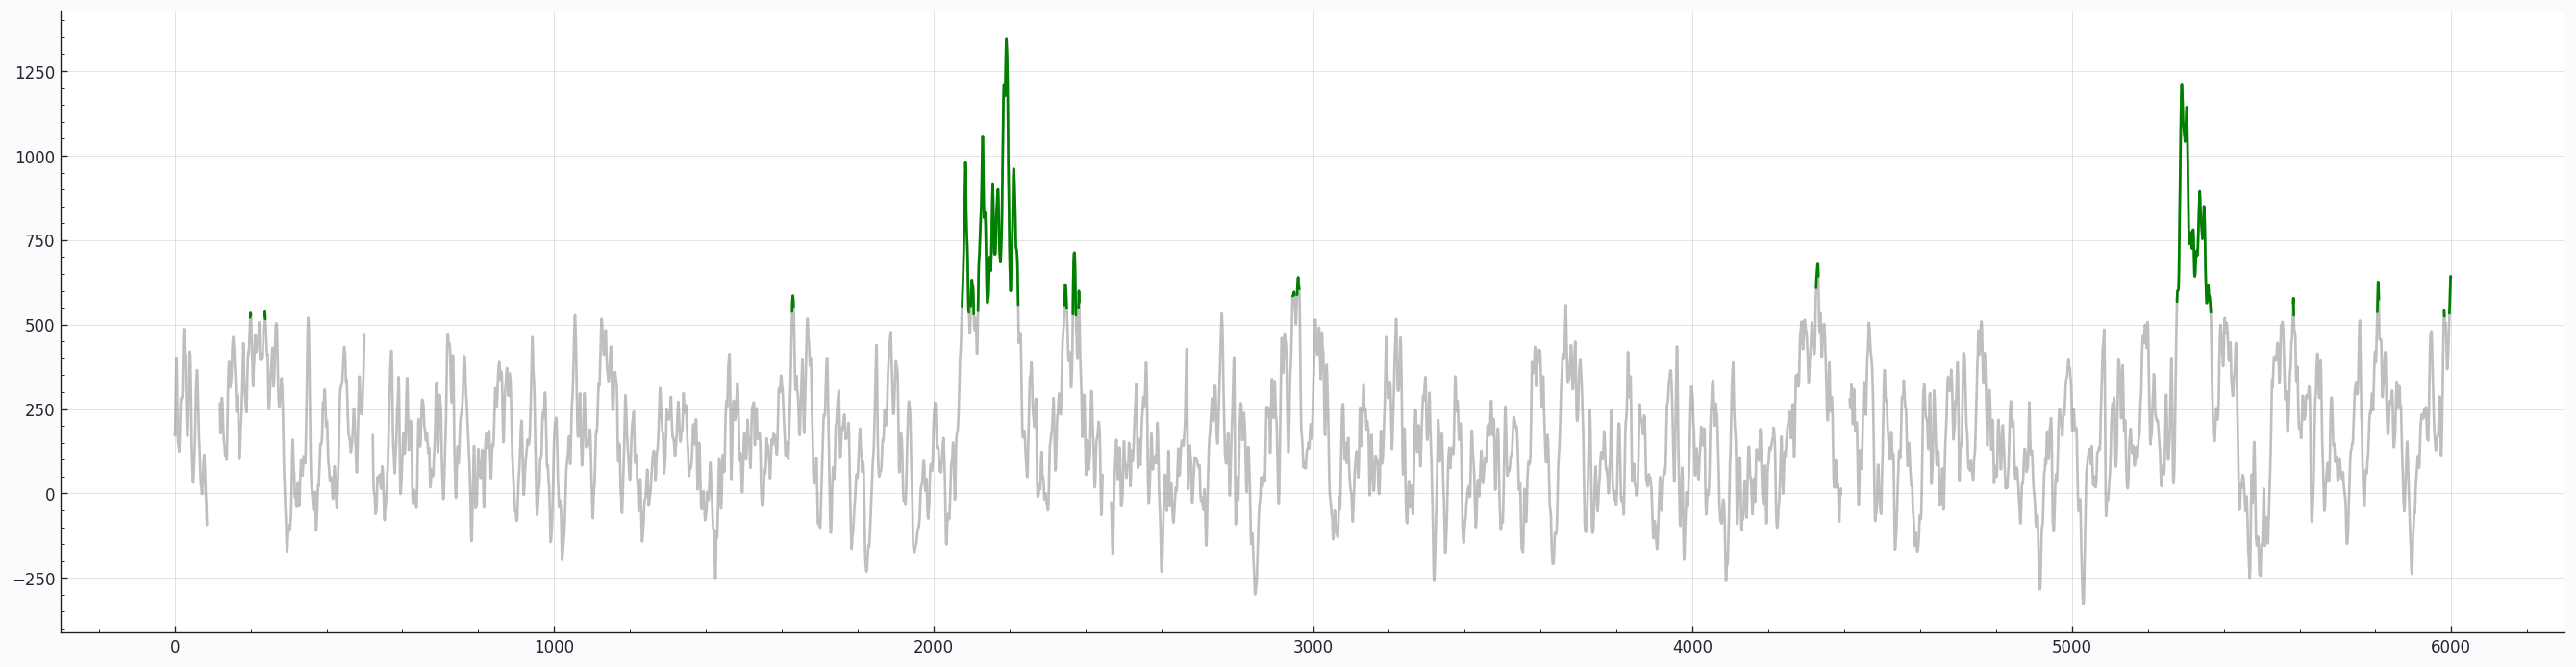

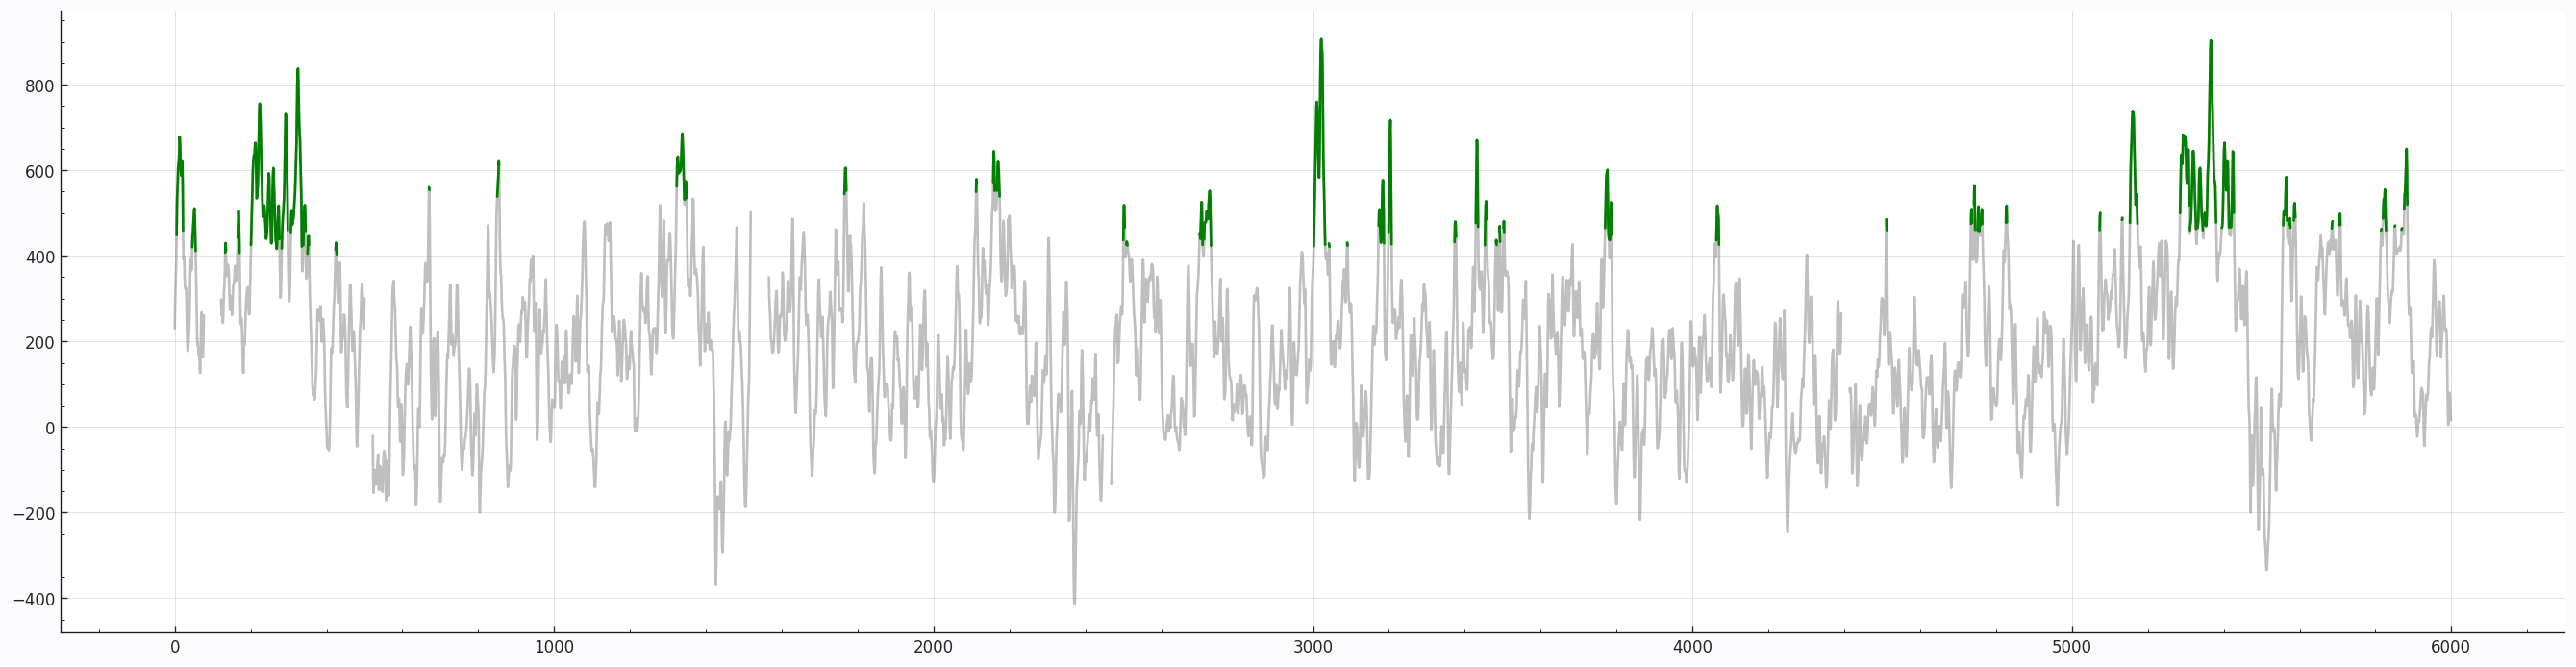

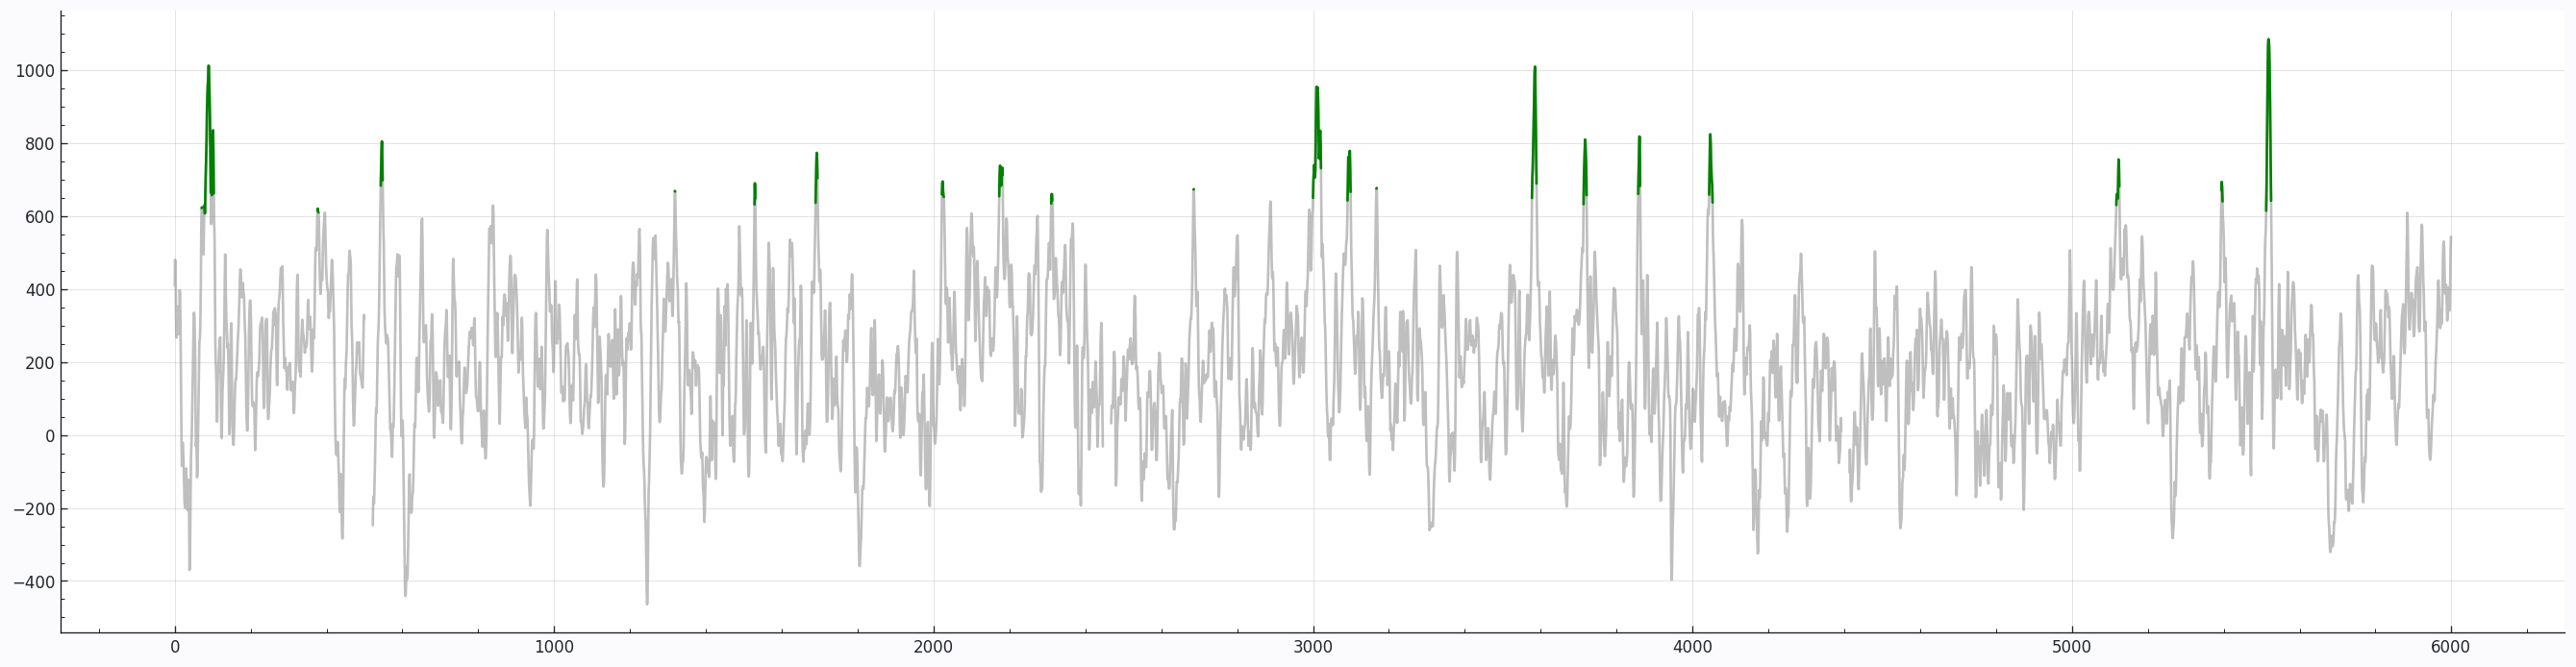

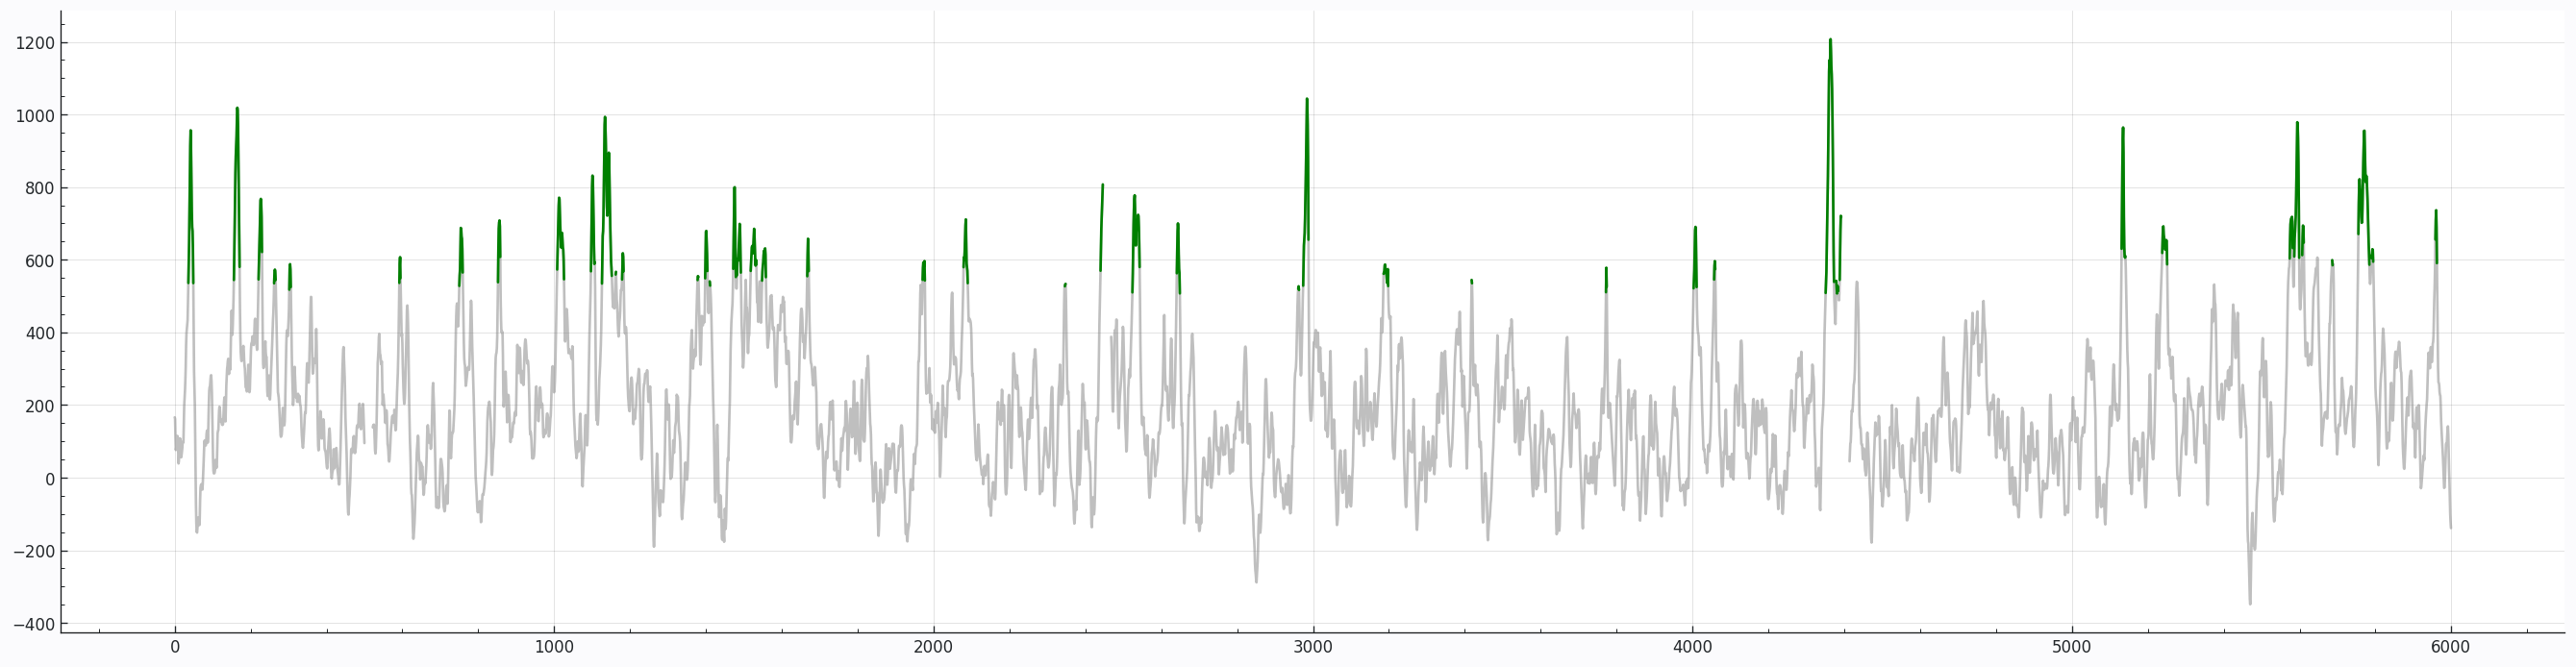

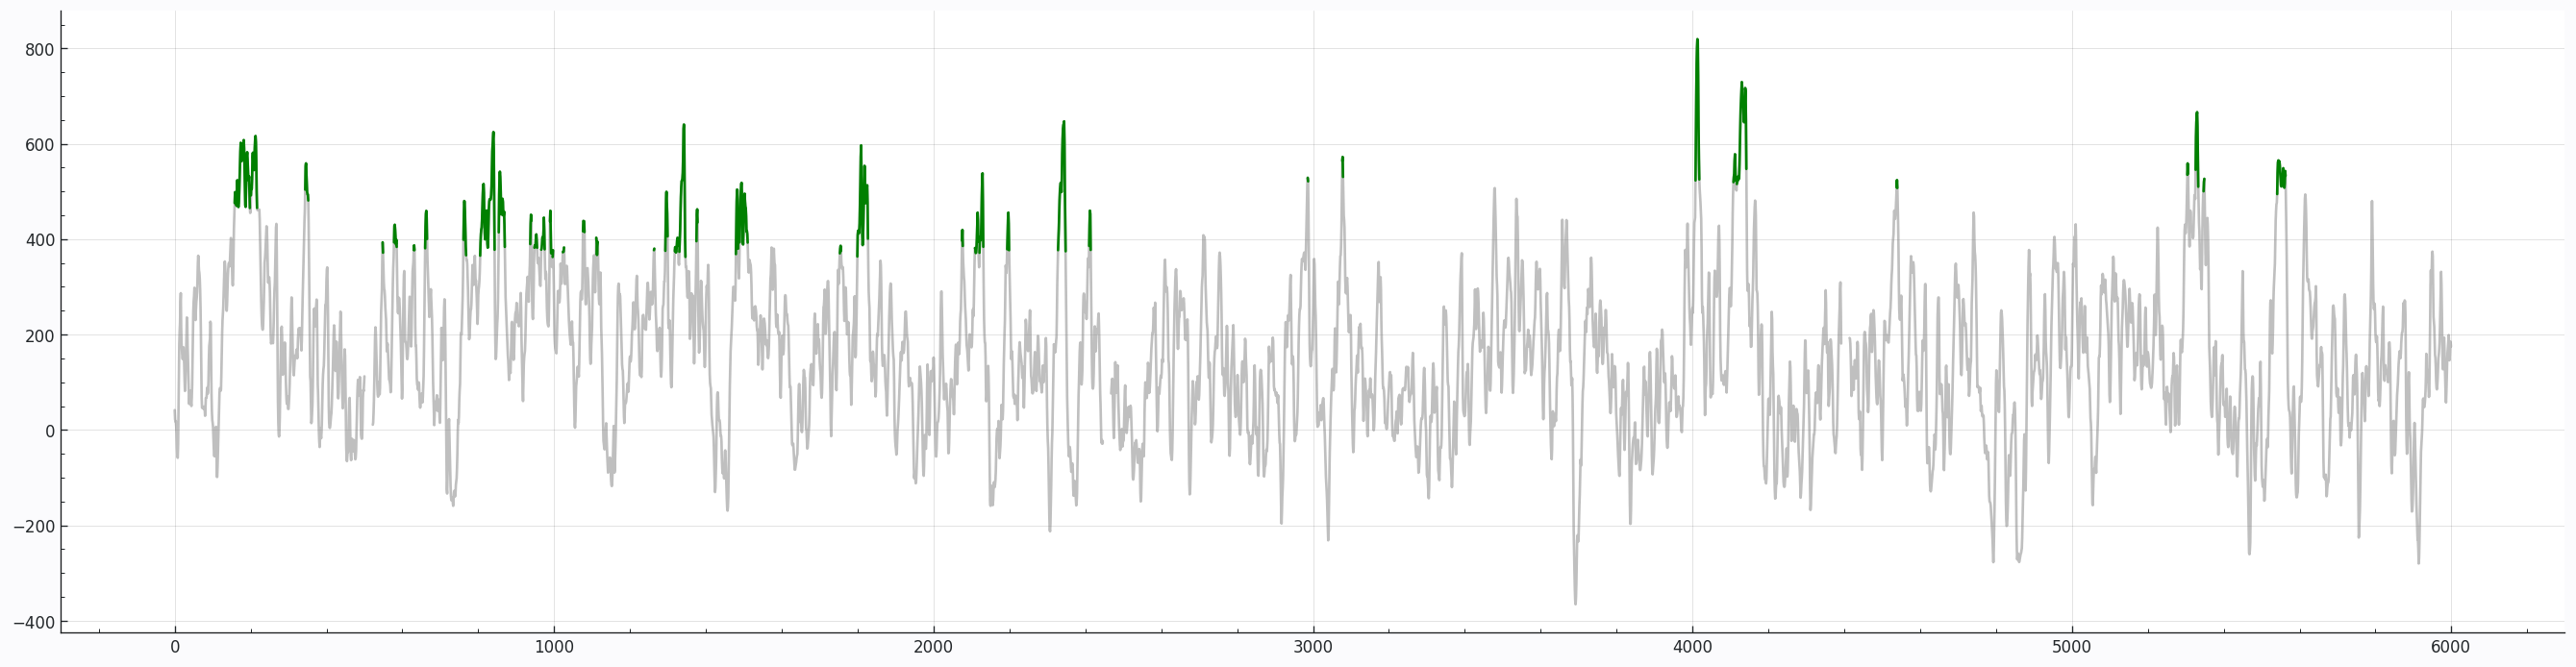

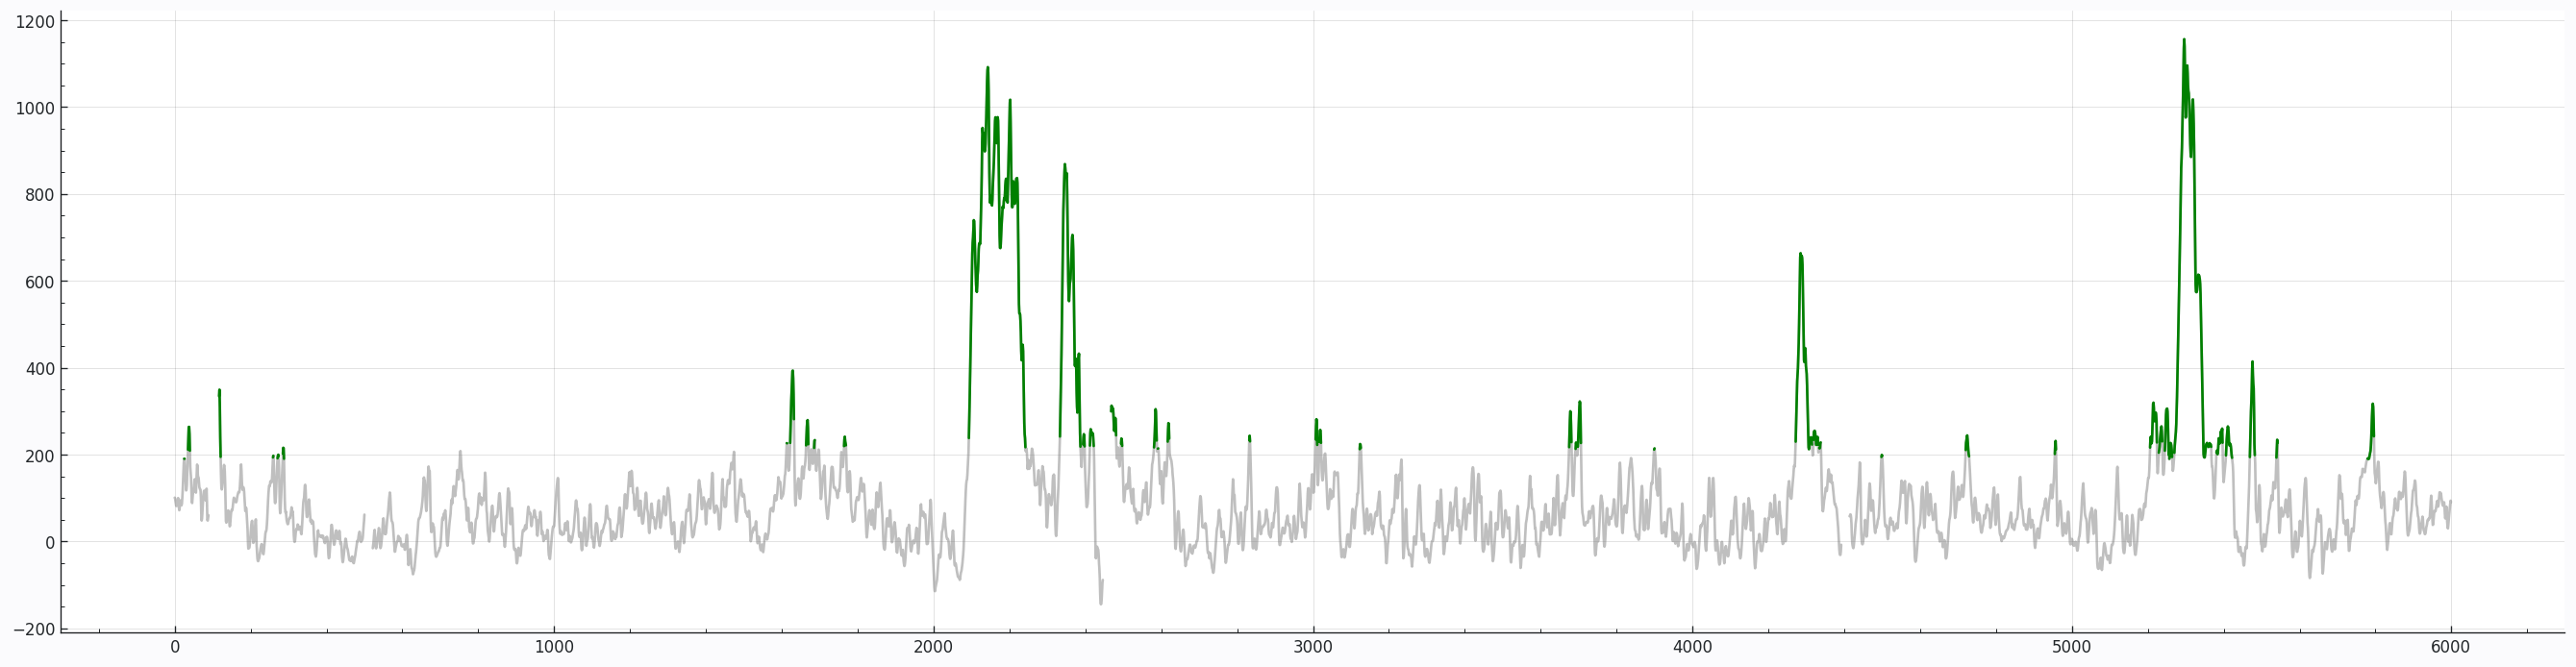

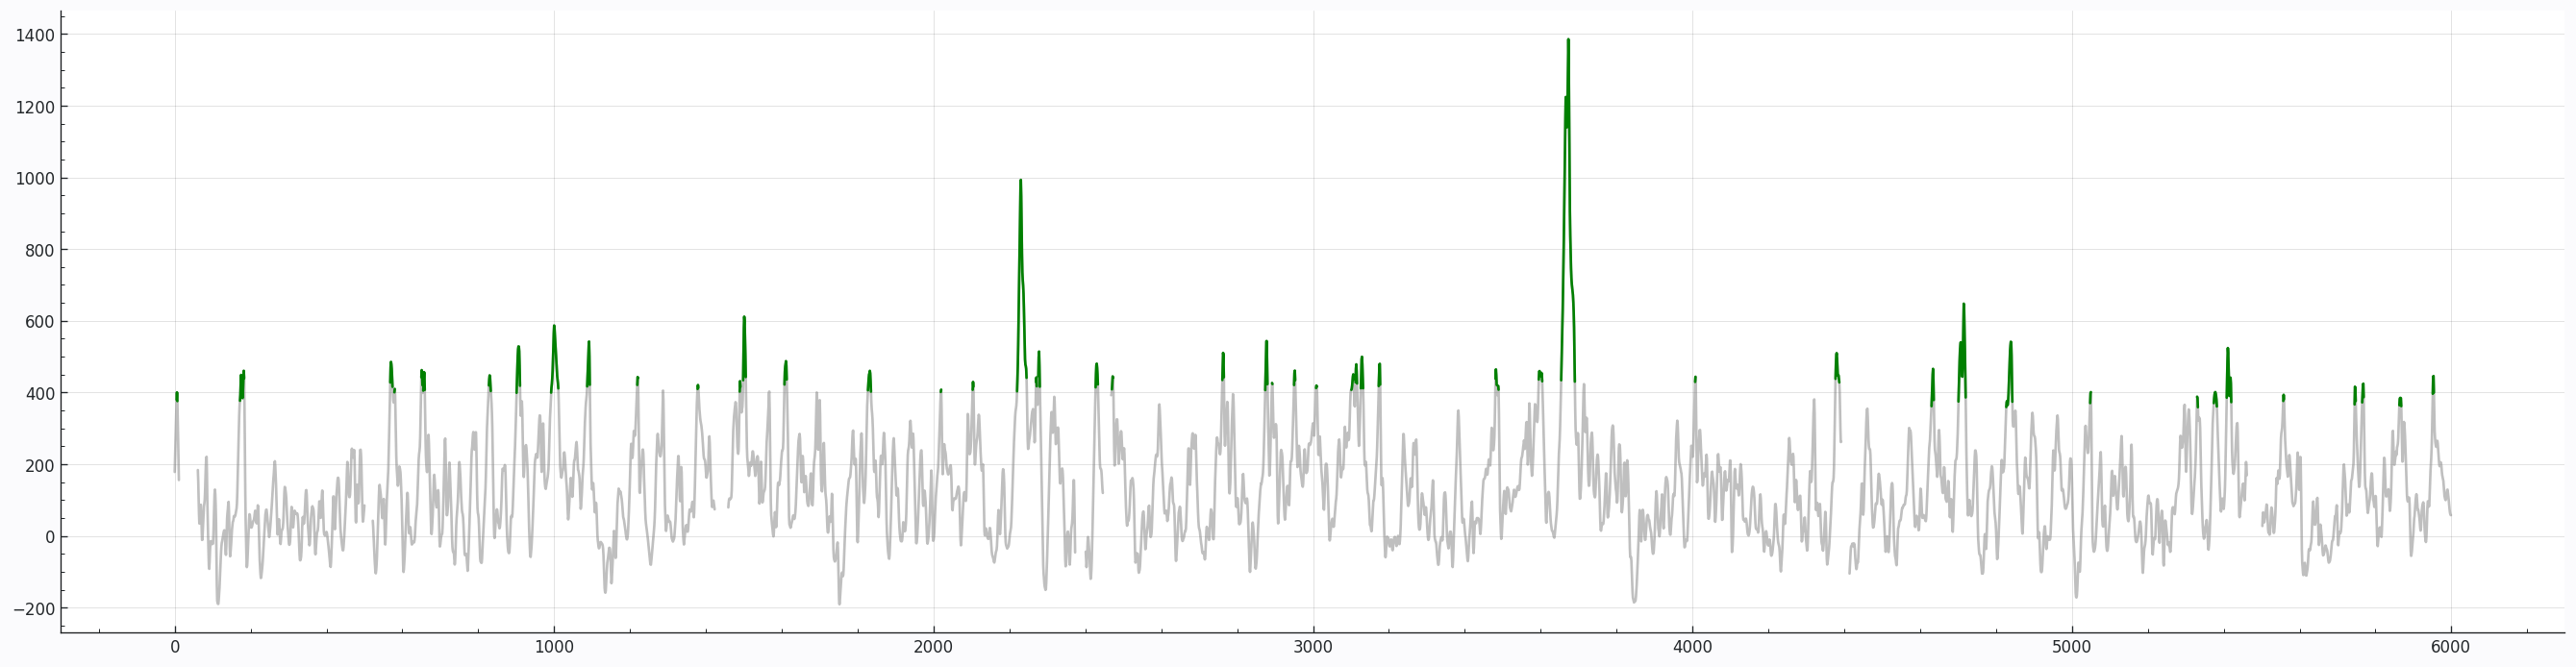

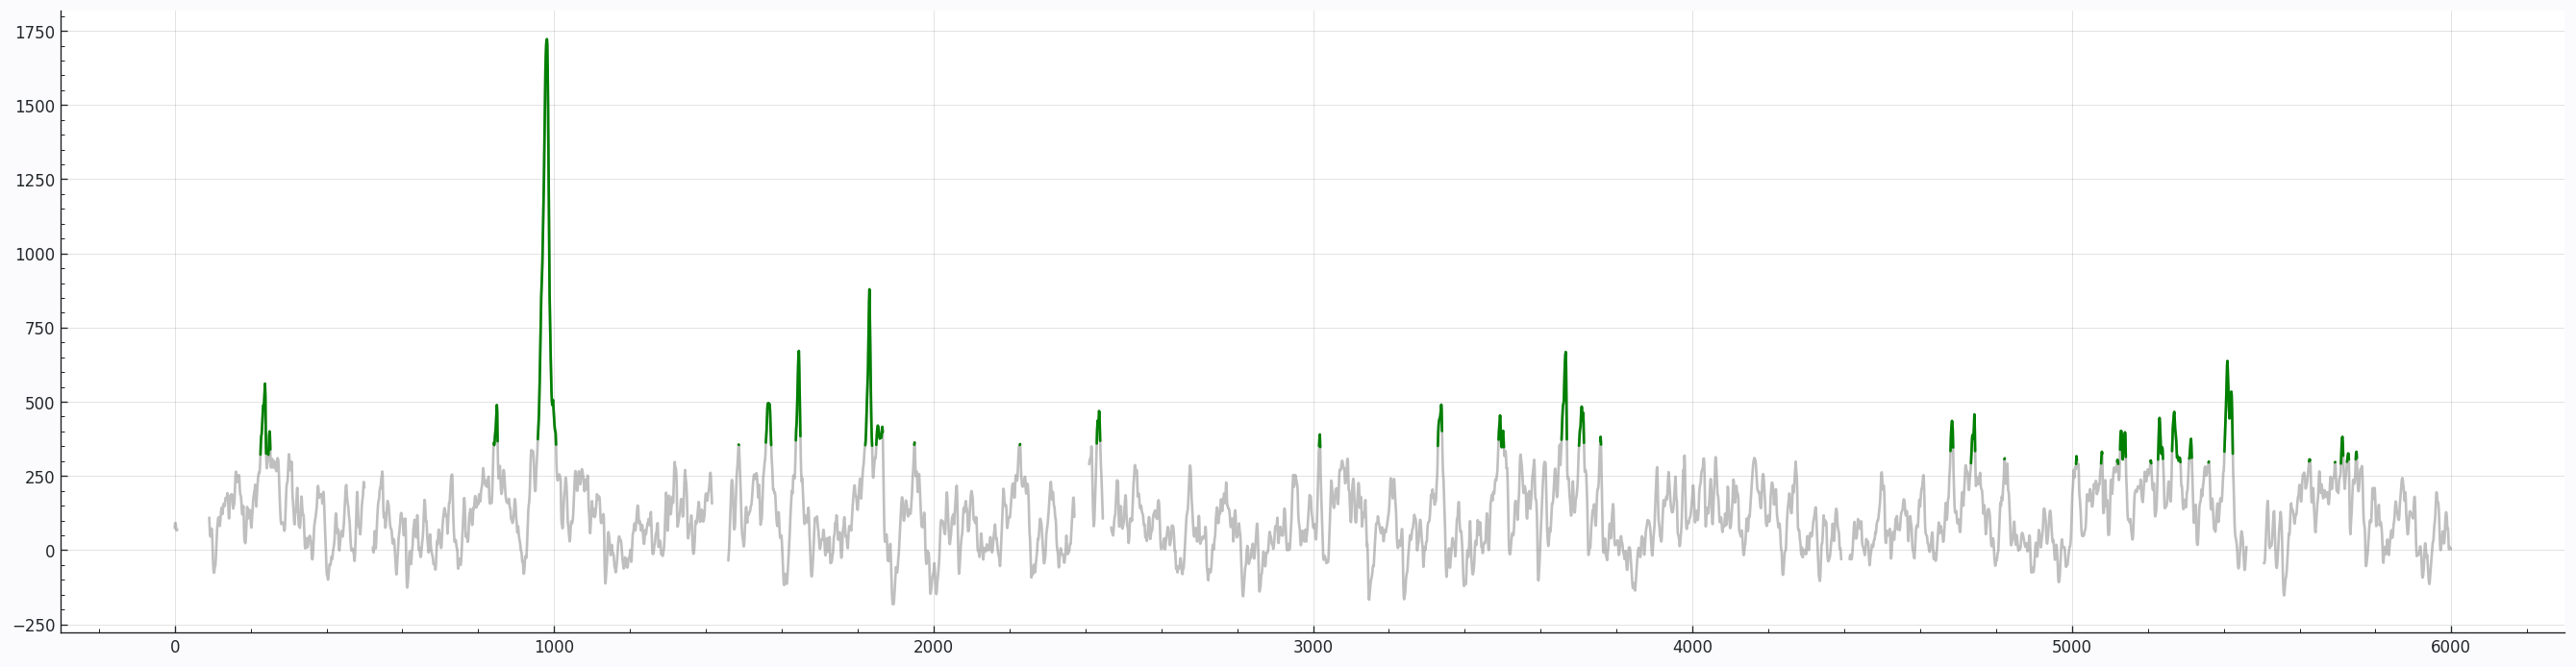

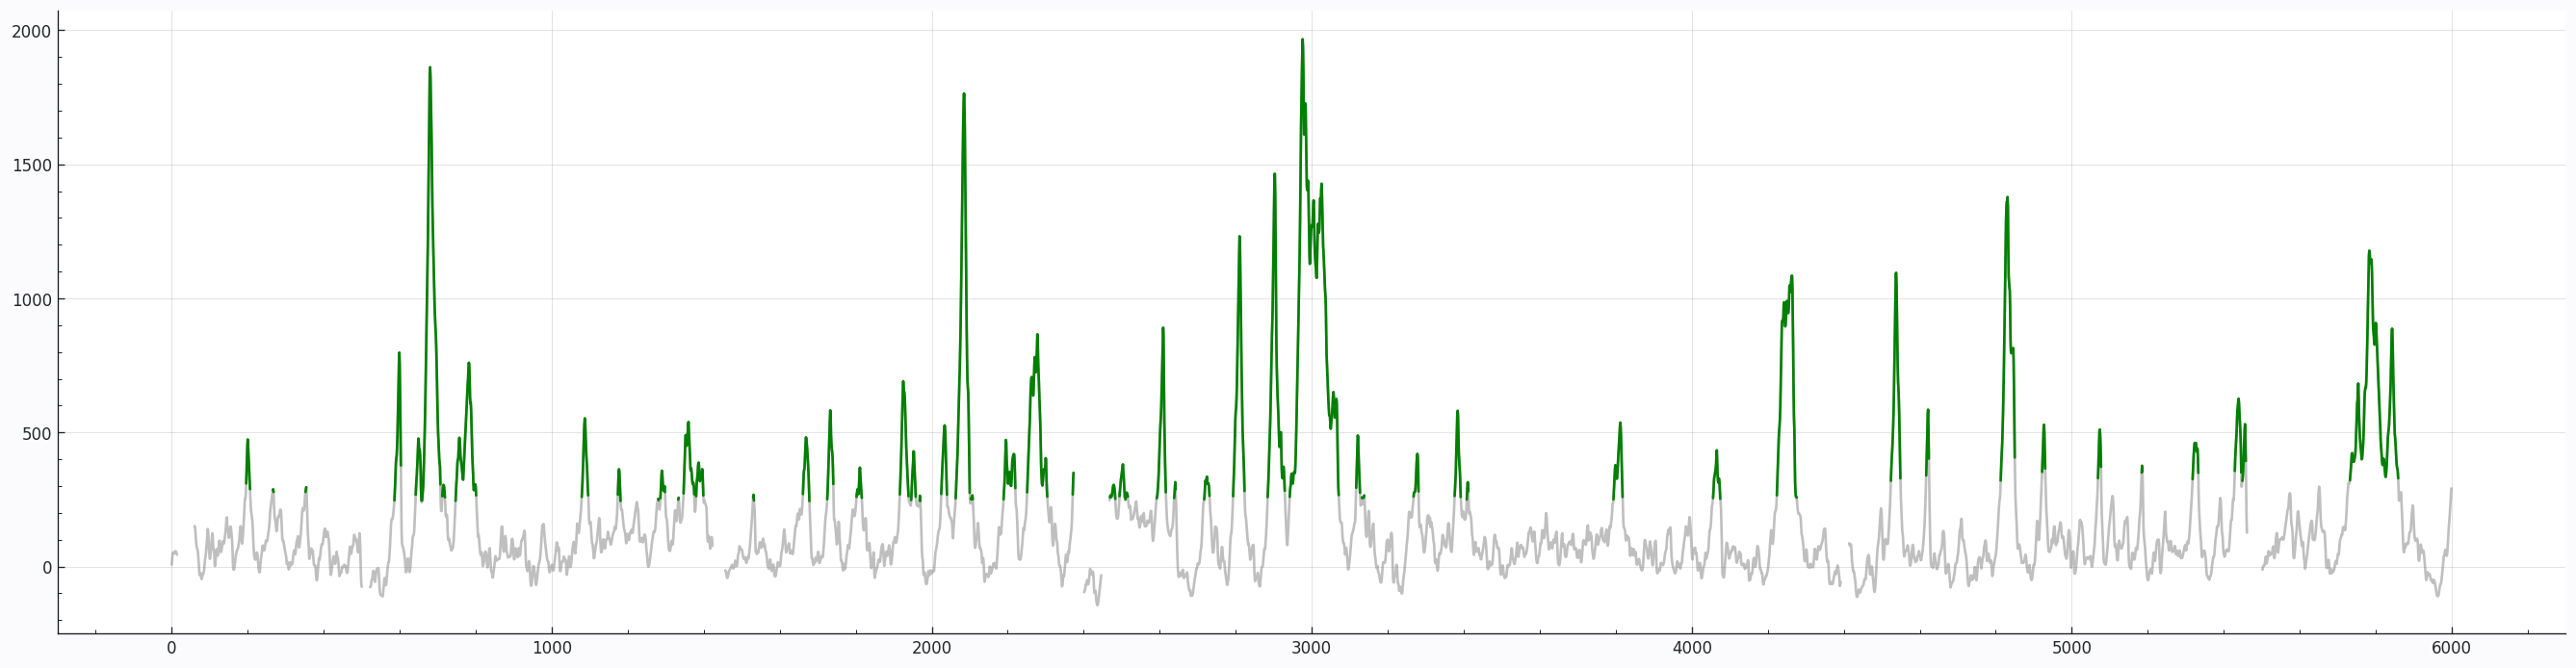

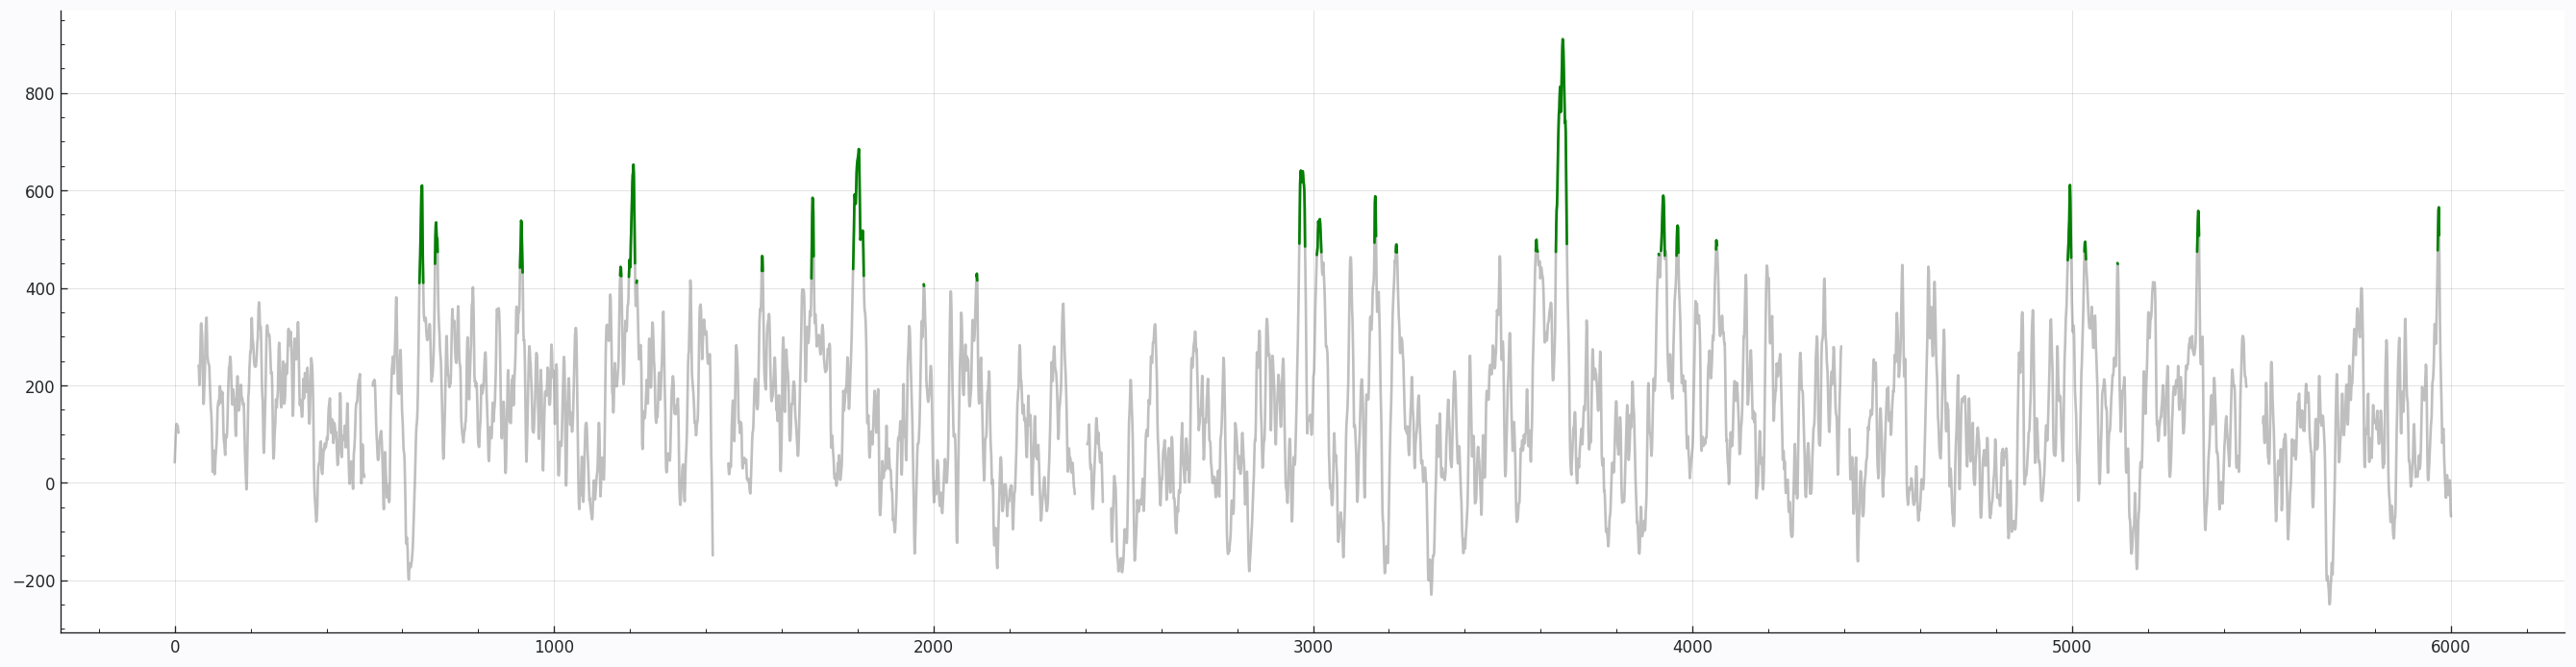

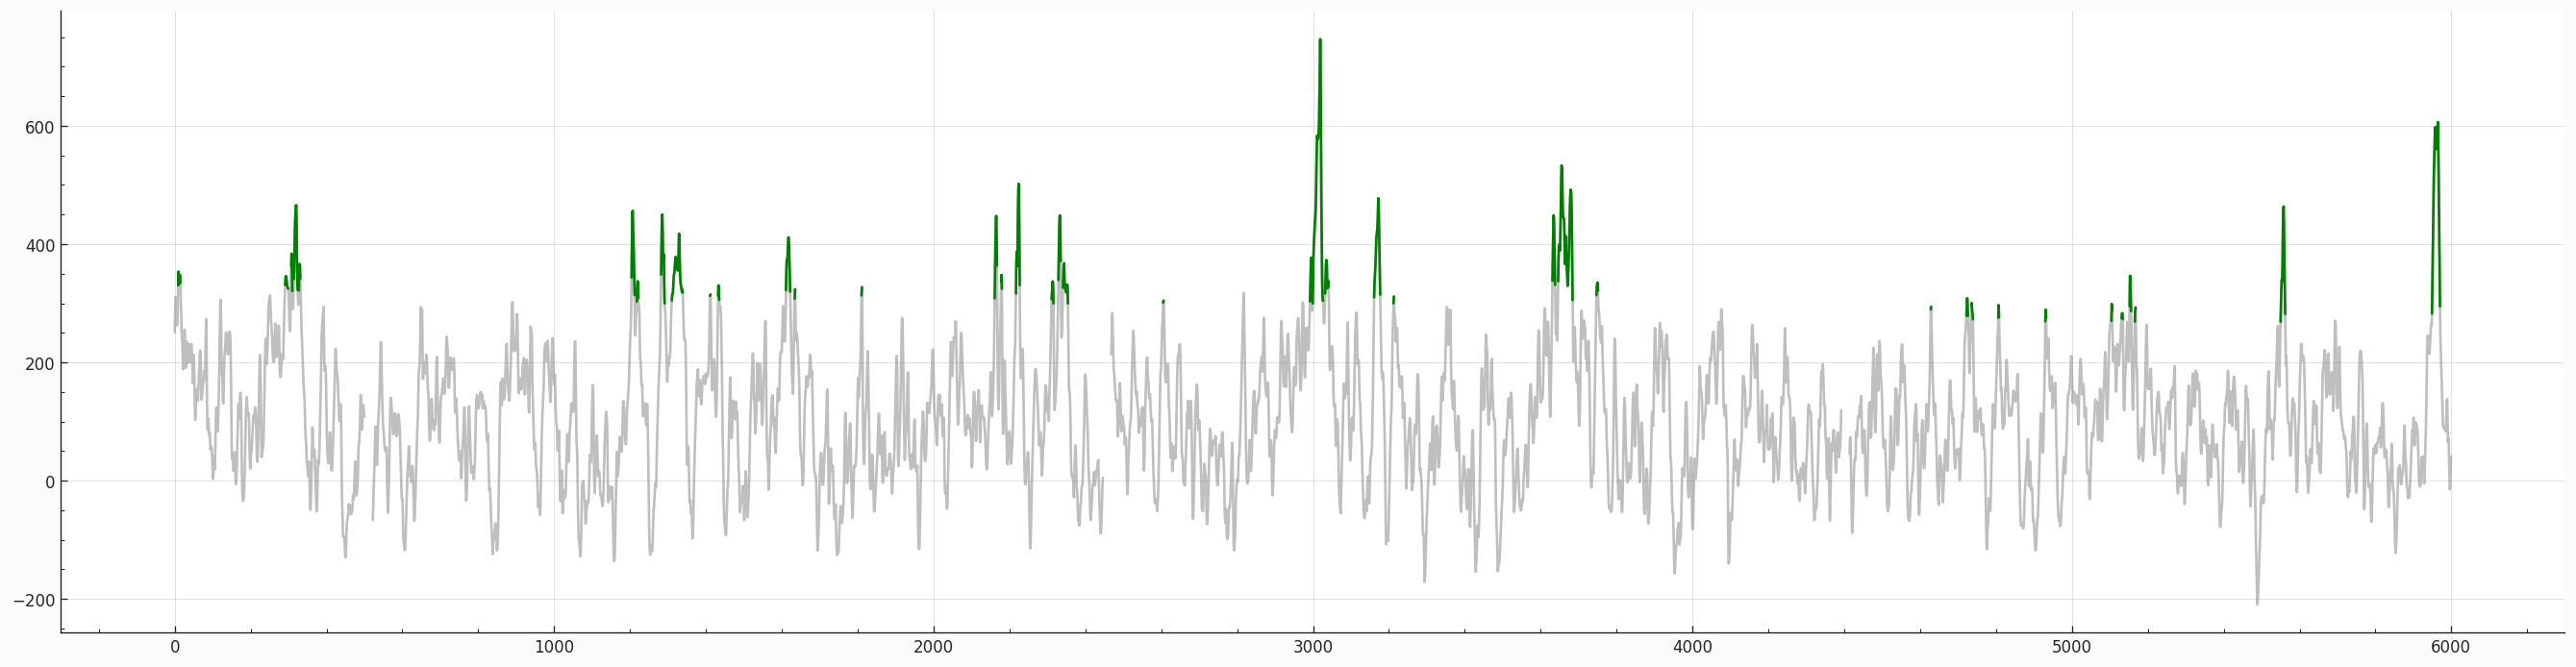

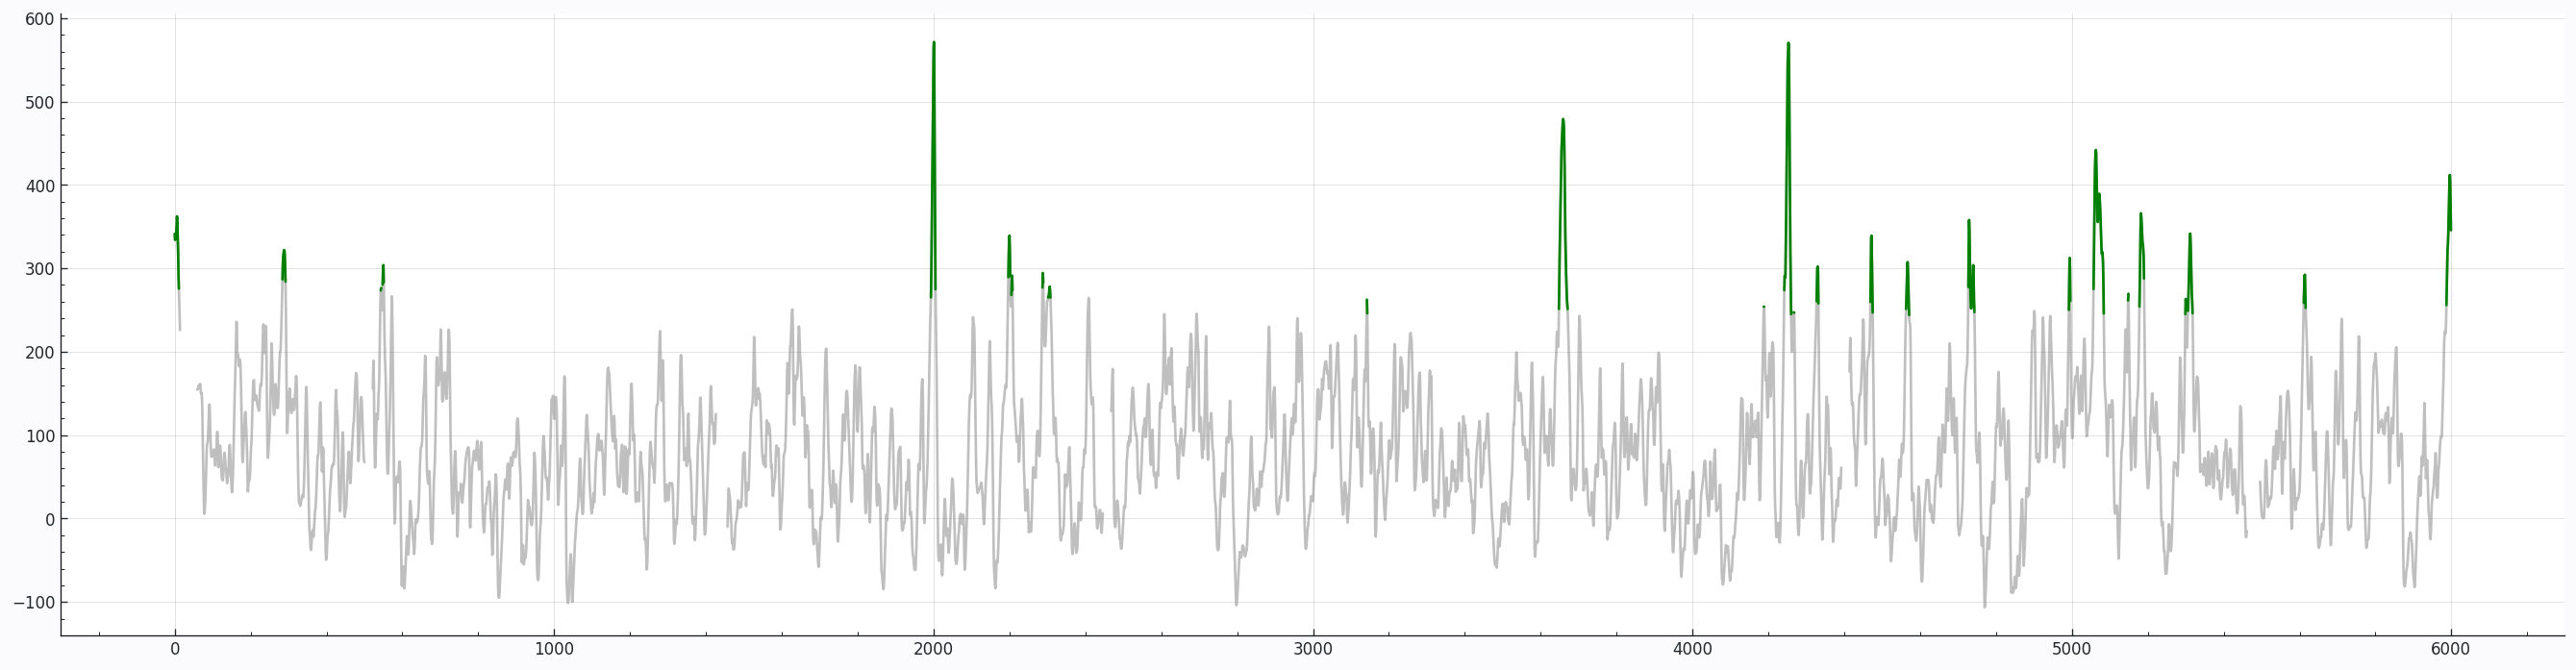

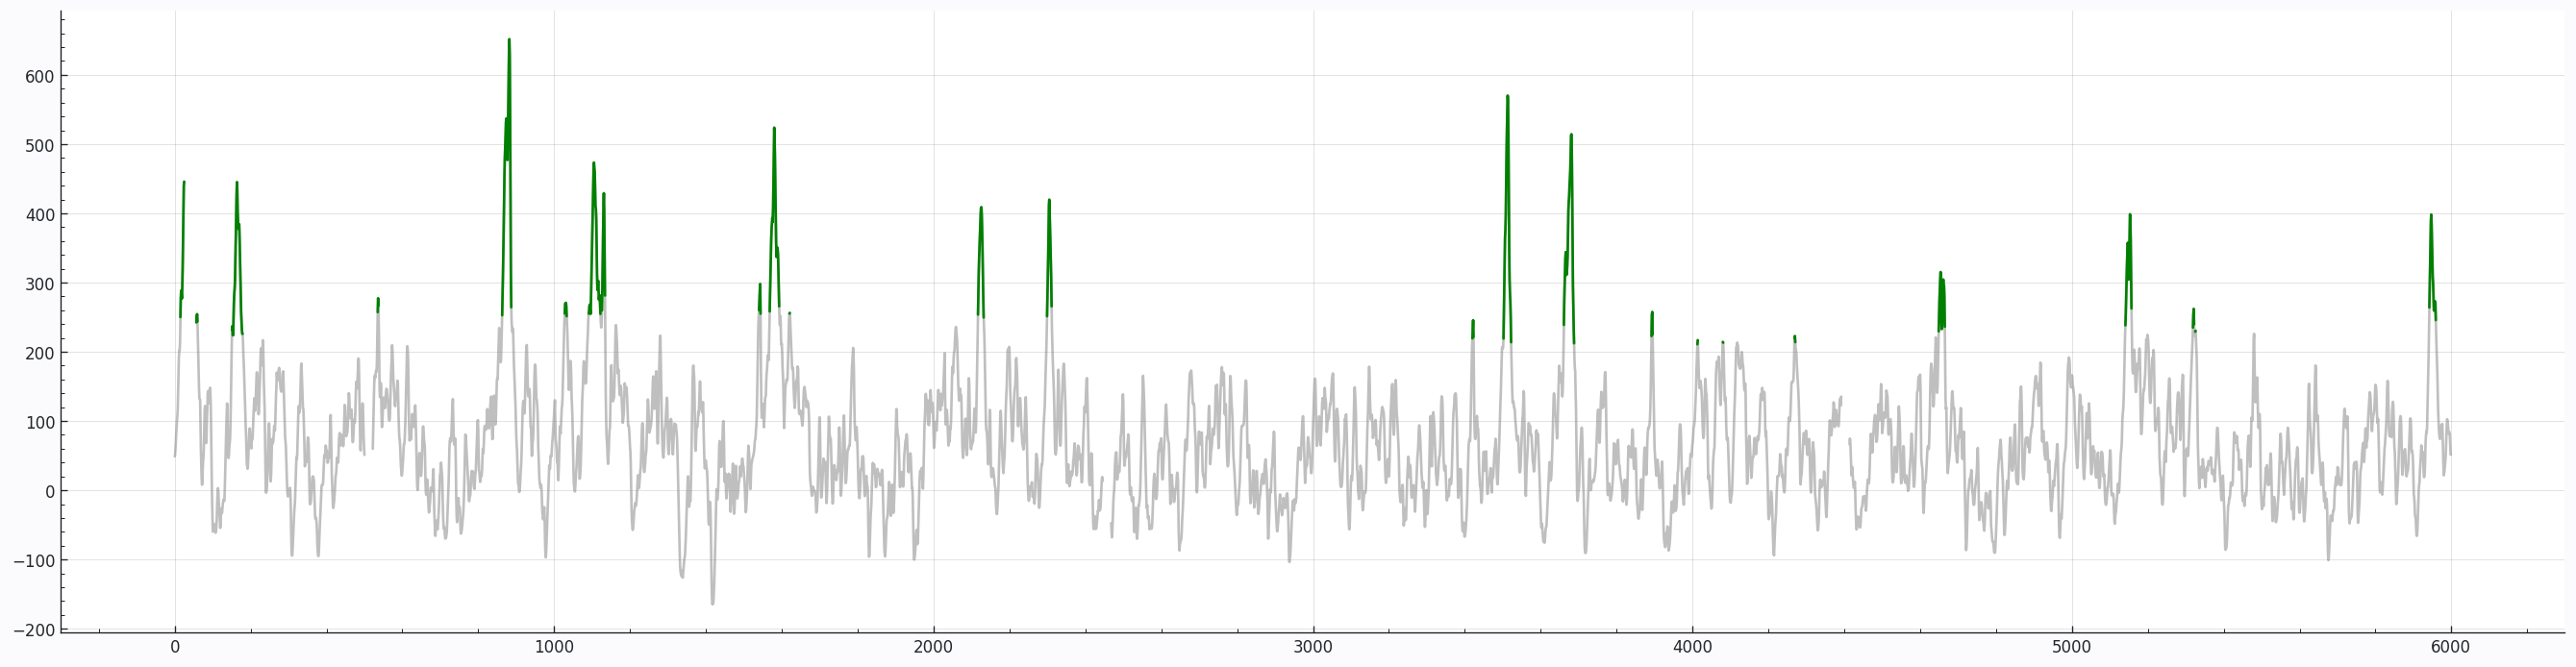

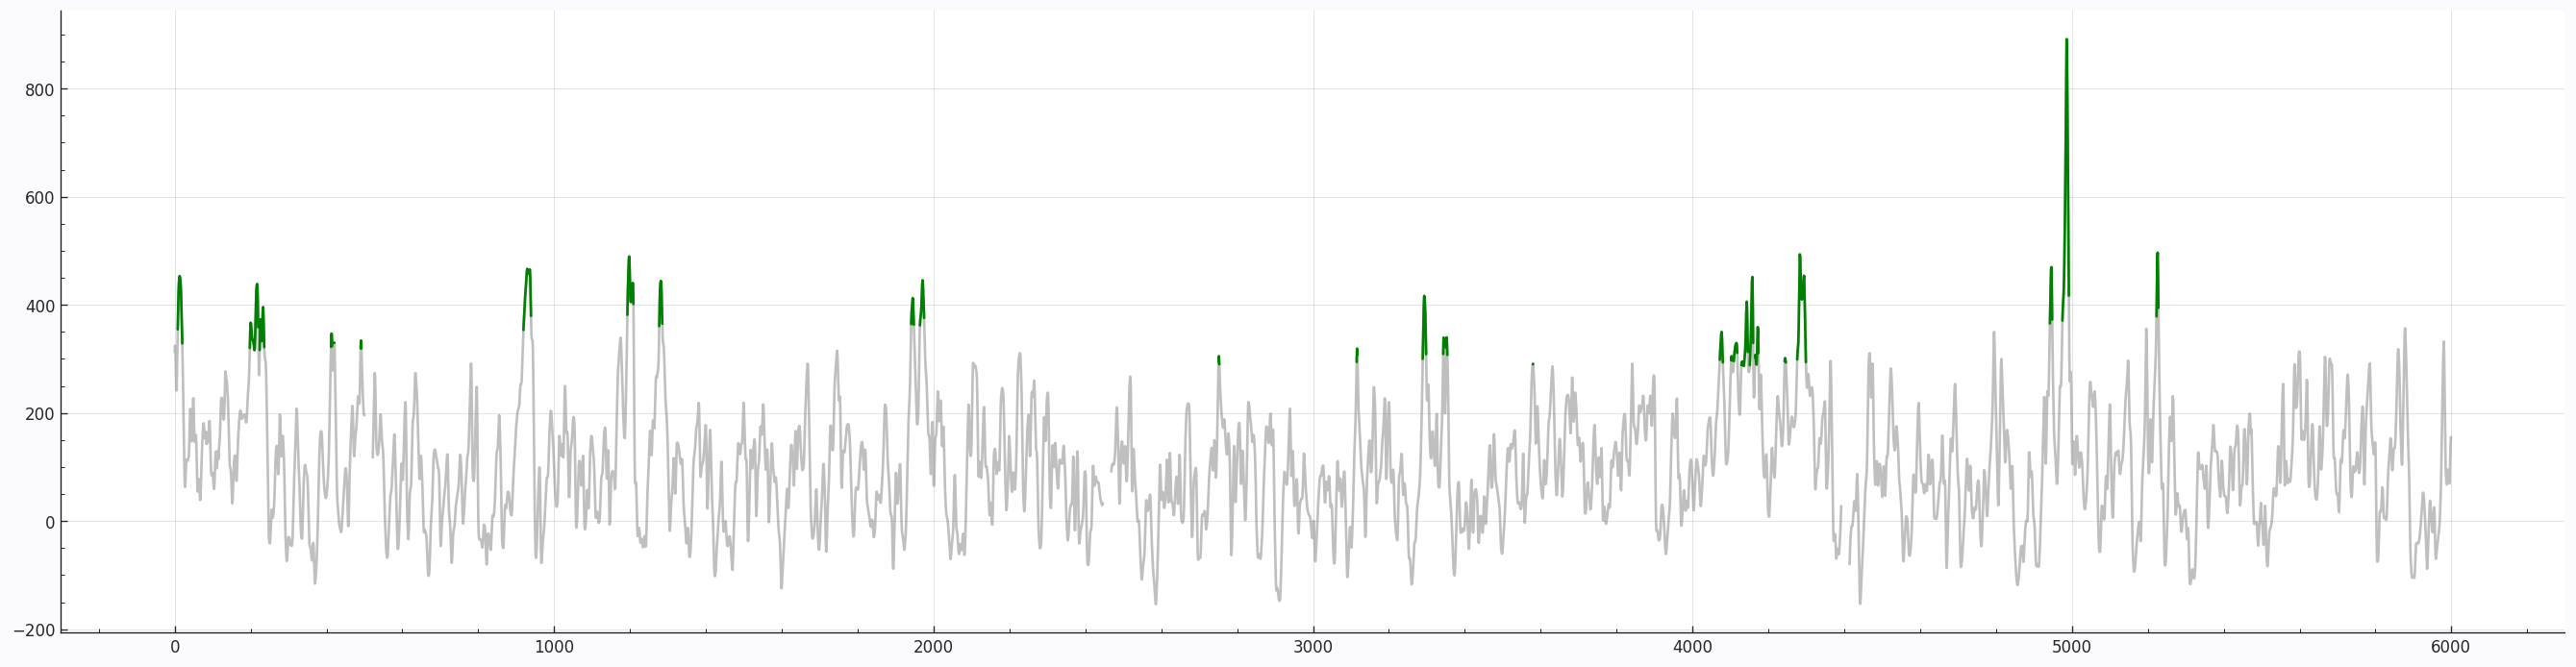

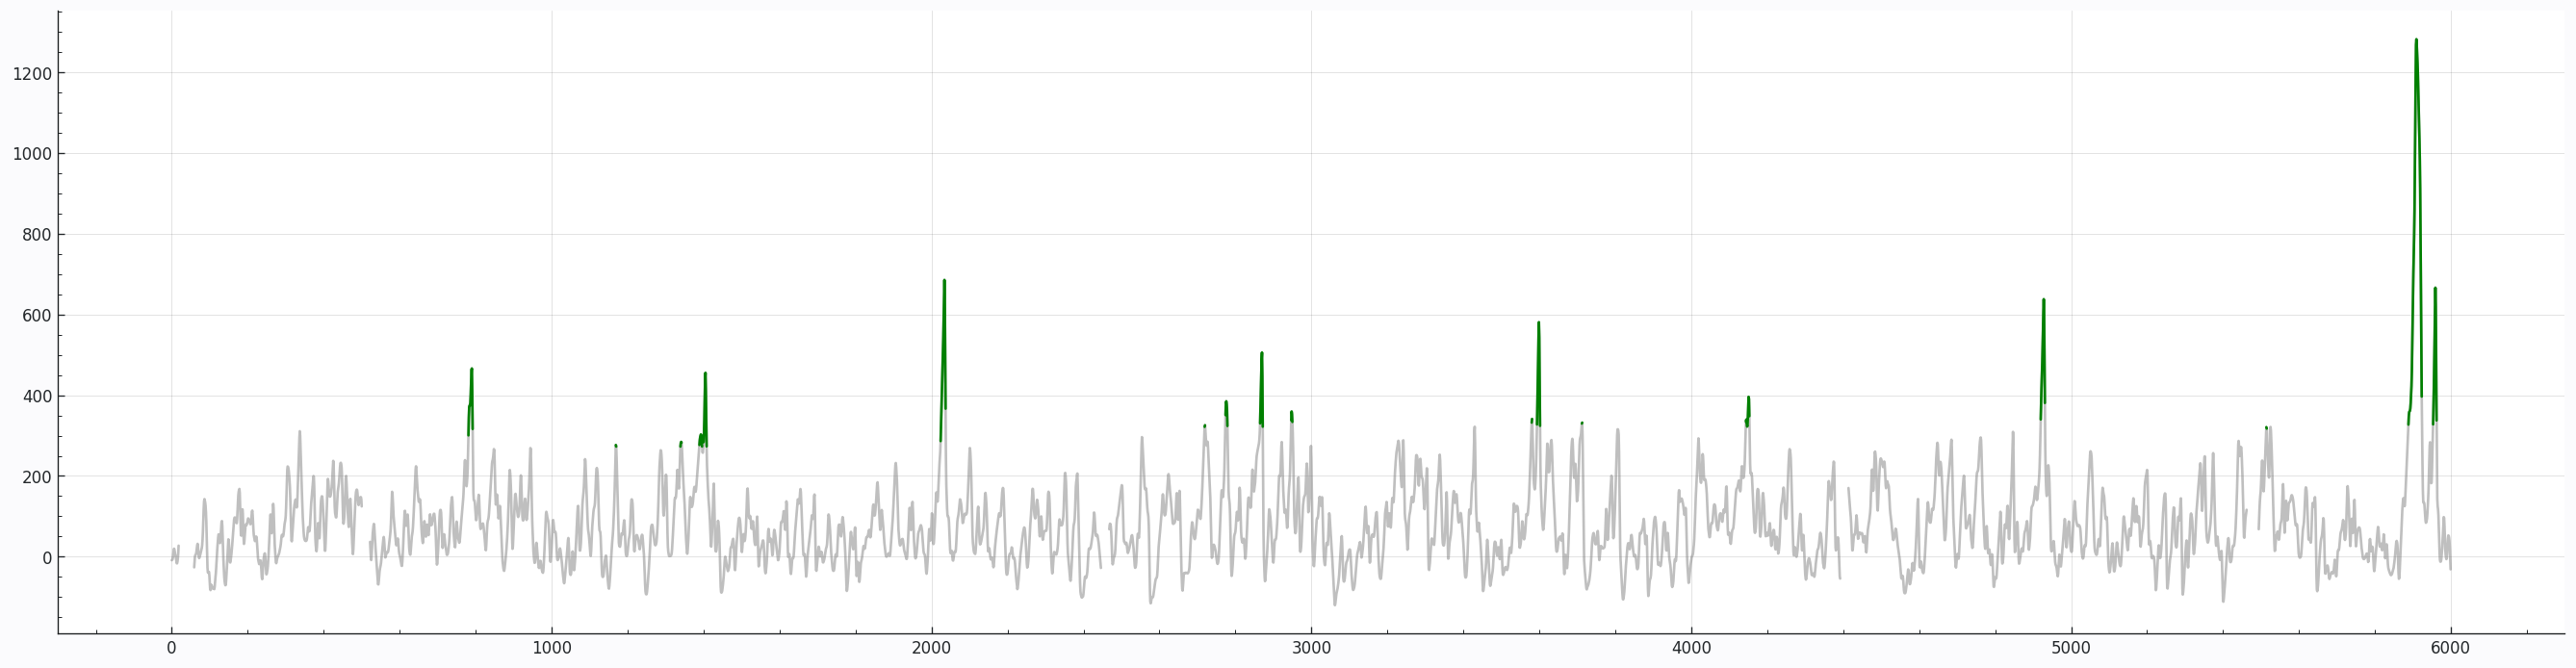

In [41]:
t_start = 7550
t1 = t_start+60
t2 = t1 + 30
dmd = 2
source_to_plot = 20
for source_to_plot in range(15):
    d2p = mf.filter((pl.col('dmd')==dmd) & (pl.col('source')==source_to_plot)).filter((pl.col('time')>=t1) & (pl.col('time')<t2))

    raw_data = d2p['data'].to_numpy()
    activity_mask = d2p['active'].to_numpy()
    active_data = np.where(activity_mask, raw_data, np.nan)
    f, ax = plt.subplots(1, 1, figsize=(28, 7))
    ax.plot(raw_data, color='gray', alpha=0.5)
    ax.plot(active_data, color='green', alpha=1)

In [22]:
from electro_py.hypno.hypno import get_states_fast

def label_df_with_states(df, h, col='datetime'):
    times = df[col].to_numpy()
    states = get_states_fast(h, times)
    states = np.array(states)
    return df.with_columns(state=pl.lit(states))

In [25]:
h = wis.peri.vig.load_auto_hypno(subject, exp, sb, filter_unclear=0.75, rename=True)

In [26]:
mf = label_df_with_states(mf, h, col='time')

In [27]:
active_sums = mf.group_by(['dmd', 'source', 'state']).agg(pl.col('active').sum())
active_sums = active_sums.sort(['dmd', 'source', 'state'])

In [28]:
total_counts = mf.group_by(['dmd', 'source', 'state']).agg(pl.count())
total_counts = total_counts.sort(['dmd', 'source', 'state'])

/tmp/ipykernel_1578037/1176419940.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  total_counts = mf.group_by(['dmd', 'source', 'state']).agg(pl.count())


In [29]:
total_counts = total_counts.rename({'count': 'total_counts'})

In [30]:
active_sums = active_sums.join(total_counts, on=['dmd', 'source', 'state'])

In [31]:
active_sums = active_sums.with_columns(
    (pl.col('active') / pl.col('total_counts')).alias('active_ratio')
)

In [32]:
# for each source on each dmd, get the NREM/wake active ratio
active_sums = active_sums.sort(['dmd', 'source', 'state'])

In [33]:
dmds = active_sums.filter(pl.col('state')=='NREM')['dmd']
sources = active_sums.filter(pl.col('state')=='NREM')['source']

In [34]:
rem_ratios = active_sums.filter(pl.col('state')=='REM')['active_ratio'].to_numpy()
nrem_ratios = active_sums.filter(pl.col('state')=='NREM')['active_ratio'].to_numpy()
wake_ratios = active_sums.filter(pl.col('state')=='Wake')['active_ratio'].to_numpy()

In [35]:
nrem_wake_ratio = nrem_ratios / wake_ratios
rem_wake_ratio = rem_ratios / wake_ratios
rem_nrem_ratio = rem_ratios / nrem_ratios

In [36]:
sr = pl.DataFrame({
    'dmd': dmds,
    'source': sources,
    'nrem_wake_ratio': nrem_wake_ratio,
    'rem_wake_ratio': rem_wake_ratio,
    'rem_nrem_ratio': rem_nrem_ratio
})

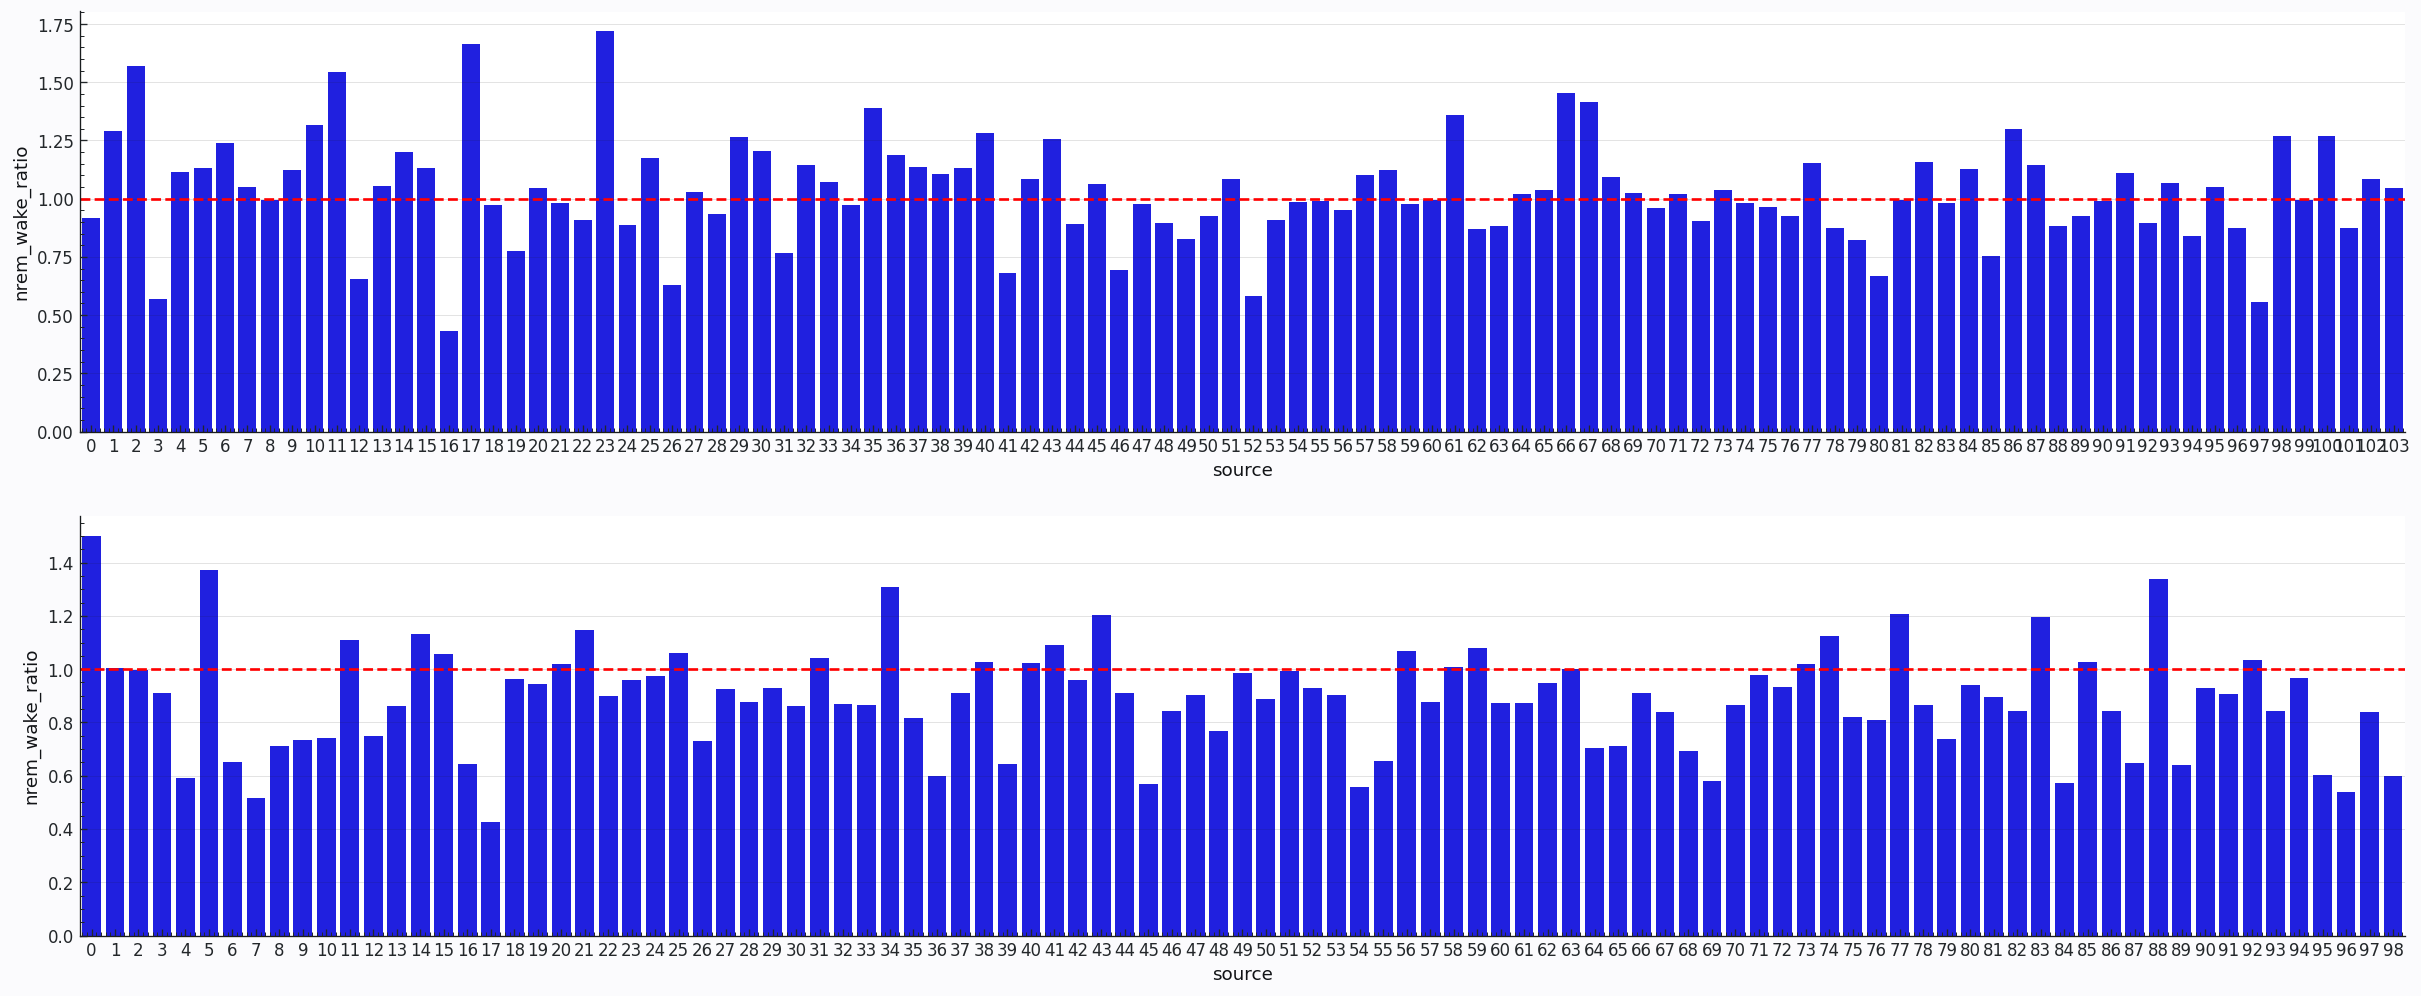

In [37]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='nrem_wake_ratio', ax=ax[0], color='blue')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='nrem_wake_ratio', ax=ax[1], color='blue')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')

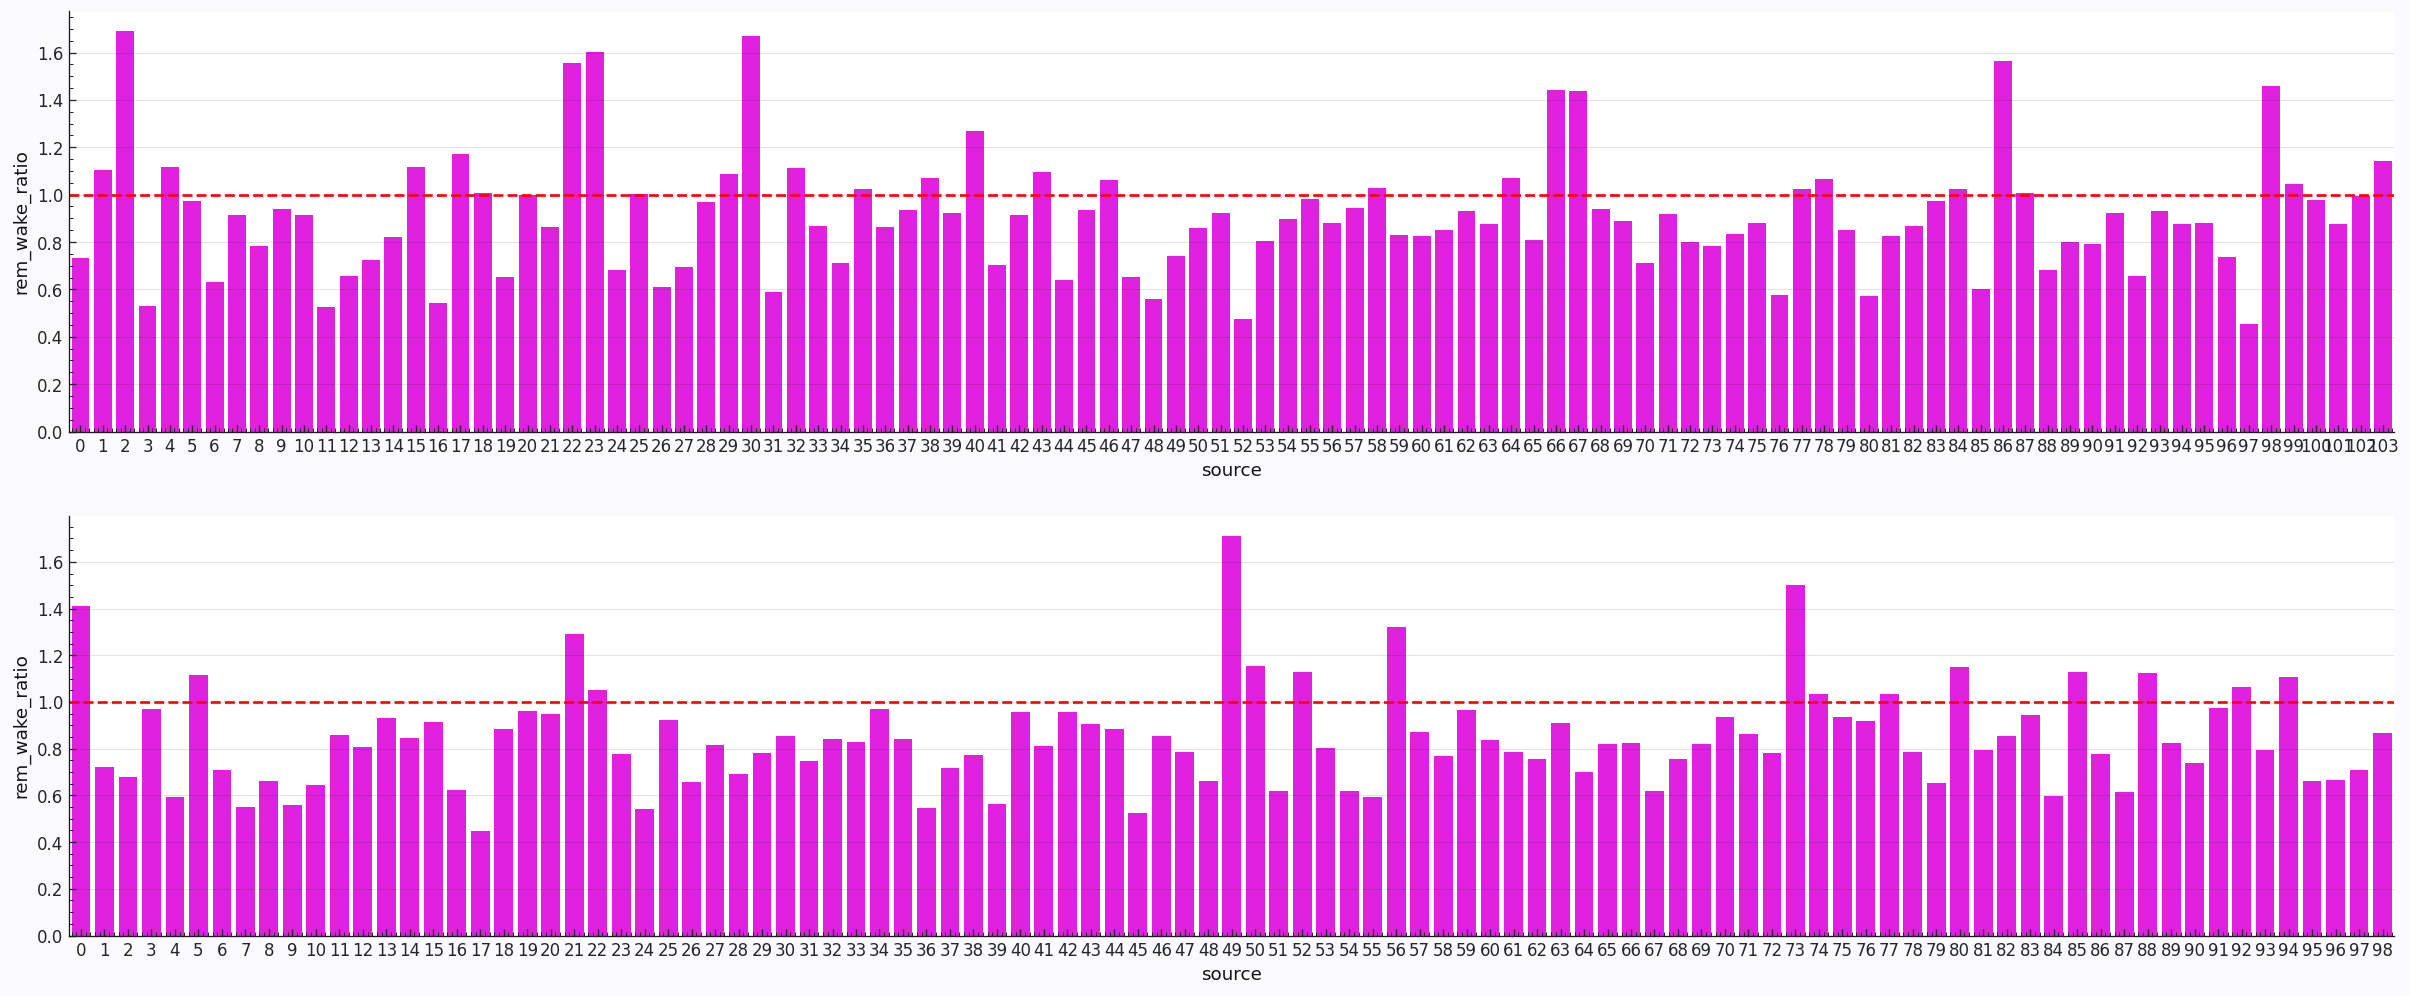

In [38]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='rem_wake_ratio', ax=ax[0], color='magenta')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='rem_wake_ratio', ax=ax[1], color='magenta')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')

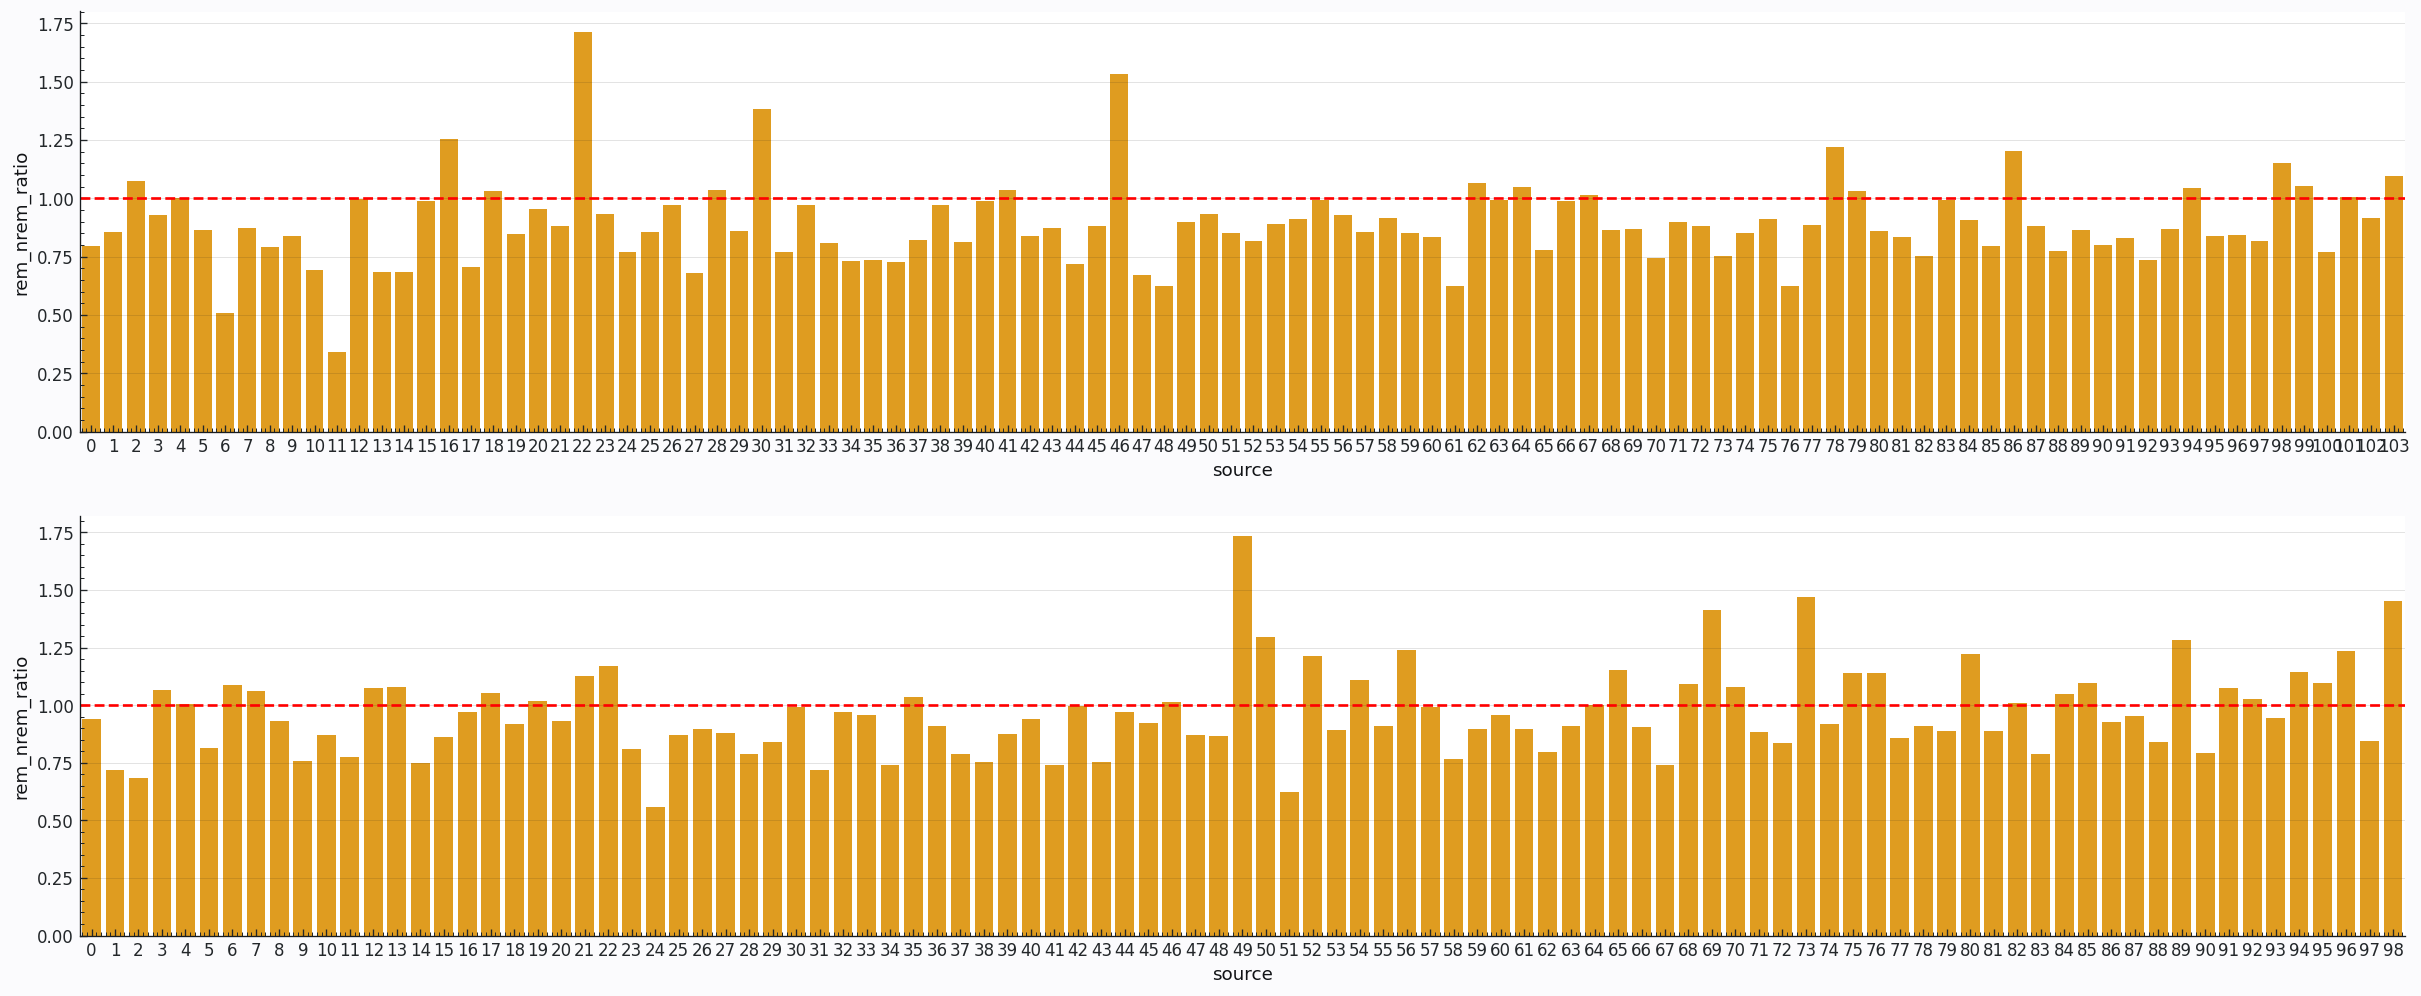

In [39]:
f, ax = plt.subplots(2, 1, figsize=(25, 10))
sns.barplot(data=sr.filter(pl.col('dmd')==1), x='source', y='rem_nrem_ratio', ax=ax[0], color='orange')
sns.barplot(data=sr.filter(pl.col('dmd')==2), x='source', y='rem_nrem_ratio', ax=ax[1], color='orange')
ax[0].axhline(1, color='red', linestyle='--')
ax[1].axhline(1, color='red', linestyle='--')